In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
import pickle
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  I_KOMP1_SAAT  I_KOMP2_HIZ  \
0     2023-04-01 00:10:00  1.634981    25.700001        8968.0          0.0   
1     2023-04-01 00:15:00  1.608970    28.400000        8968.0          0.0   
2     2023-04-01 00:20:00  1.554008    28.000000        8968.0          0.0   
3     2023-04-01 00:25:00  1.640494    30.900000        8968.0          0.0   
4     2023-04-01 00:30:00  1.590494    25.000000        8968.0          0.0   
...                   ...       ...          ...           ...          ...   
59623 2023-10-25 00:45:00  1.611181    26.400000       13761.0          0.0   
59624 2023-10-25 00:50:00  1.831158    39.200001       13761.0          0.0   
59625 2023-10-25 00:55:00  1.627907    44.000000       13761.0          0.0   
59626 2023-10-25 01:00:00  1.590126     0.000000       13761.0          0.0   
59627 2023-10-25 01:05:00  1.773319    55.700001       13761.0          0.0   

       I_KOMP2_SAAT  I_NEM_SET  I_SIC_SET  II_KOMP1_HIZ  II_KOMP1_SAAT  ...  \
0               3.0       45.0       23.0     34.700001        12770.0  ...   
1               3.0       45.0       23.0     39.900002        12770.0  ...   
2               3.0       45.0       23.0     36.900002        12770.0  ...   
3               3.0       45.0       23.0     38.500000        12770.0  ...   
4               3.0       45.0       23.0     38.500000        12771.0  ...   
...             ...        ...        ...           ...            ...  ...   
59623           3.0       45.0       22.0      0.000000        17241.0  ...   
59624           3.0       45.0       22.0     49.700001        17241.0  ...   
59625           3.0       45.0       22.0      0.000000        17241.0  ...   
59626           3.0       45.0       22.0     29.400000        17241.0  ...   
59627           3.0       45.0       22.0      0.000000        17241.0  ...   

       month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0            0        0        1        0        0        0        0        0   
1            0        0        1        0        0        0        0        0   
2            0        0        1        0        0        0        0        0   
3            0        0        1        0        0        0        0        0   
4            0        0        1        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
59623        0        0        0        0        0        0        0        0   
59624        0        0        0        0        0        0        0        0   
59625        0        0        0        0        0        0        0        0   
59626        0        0        0        0        0        0        0        0   
59627        0        0        0        0        0        0        0        0   

       month_10  month_11  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
...         ...       ...  
59623         1         0  
59624         1         0  
59625         1         0  
59626         1         0  
59627         1         0  

[59628 rows x 78 columns]

In [3]:
## PUE detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] > 2.5) | (FINAL_DF['PUE'] < 1)]

## REPLACE OUTLIERS WITH THE MEAN OF THE ADJACENT VALUES
for i in outliers.index:
    if i == 0:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i + 1, 'PUE']
    elif i == len(FINAL_DF) - 1:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i - 1, 'PUE']
    else:
        FINAL_DF.loc[i, 'PUE'] = (FINAL_DF.loc[i - 1, 'PUE'] + FINAL_DF.loc[i + 1, 'PUE']) / 2


In [4]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
HOURS = ['hour_' + str(hour) for hour in range(24)]
MONTHS = ['month_' + str(month) for month in range(4, 11)]
column_names = ['Timestamp', 'PUE',
                    
                    'I_KOMP1_HIZ', 
                    #'I_KOMP1_SAAT',
                    #'I_KOMP2_HIZ', 
                    #'I_KOMP2_SAAT',
                    #'I_NEM_SET','I_SIC_SET', 
                    
                    'II_KOMP1_HIZ', 
                    #'II_KOMP1_SAAT',
                    #'II_KOMP2_HIZ',
                    #'II_KOMP2_SAAT',
                    #'II_NEM_SET','II_SIC_SET', 
                    
                    'III_KOMP1_HIZ', 
                    #'III_KOMP1_SAAT',
                    #'III_KOMP2_HIZ', 
                    #'III_KOMP2_SAAT',
                    #'III_NEM_SET','III_SIC_SET', 
                    
                    'IV_KOMP1_HIZ', 
                    #'IV_KOMP1_SAAT',
                    #'IV_KOMP2_HIZ', 
                    #'IV_KOMP2_SAAT',
                    #'IV_NEM_SET',
                    'KS10_UDP_TUKETIM',
                    'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC',
                    'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC', 
                    'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
                    
                    'SENSOR_I_TEMP', 'SENSOR_II_TEMP', 
                    'OUTLET_TEMP', 'OUTLET_HUMIDITY'] + DAYS + HOURS + MONTHS

In [5]:
FINAL_DF = FINAL_DF.loc[:, column_names]

In [6]:
# add extra columns

#FINAL_DF["PUE_lag_" + str(1)] = FINAL_DF["PUE"].shift(1)
FINAL_DF["PUE_lag_one_day"] = FINAL_DF["PUE"].shift(24*12)
#FINAL_DF["PUE_lag_one_week"] = FINAL_DF["PUE"].shift(7*24*12)

FINAL_DF.dropna(inplace=True)
FINAL_DF.reset_index(drop=True, inplace=True)
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  II_KOMP1_HIZ  III_KOMP1_HIZ  \
0     2023-04-02 00:10:00  1.645333    31.000000     27.200001      63.900002   
1     2023-04-02 00:15:00  1.603257    29.500000     30.200001      39.900002   
2     2023-04-02 00:20:00  1.588868    37.500000     35.799999      45.900002   
3     2023-04-02 00:25:00  1.599617    29.299999     37.799999      40.700001   
4     2023-04-02 00:30:00  1.641085    39.200001     36.900002      46.700001   
...                   ...       ...          ...           ...            ...   
59335 2023-10-25 00:45:00  1.611181    26.400000      0.000000      39.200001   
59336 2023-10-25 00:50:00  1.831158    39.200001     49.700001      29.400000   
59337 2023-10-25 00:55:00  1.627907    44.000000      0.000000      29.400000   
59338 2023-10-25 01:00:00  1.590126     0.000000     29.400000      39.200001   
59339 2023-10-25 01:05:00  1.773319    55.700001      0.000000      44.500000   

       IV_KOMP1_HIZ  KS10_UDP_TUKETIM  CH1_CIKIS_SIC  CH1_GIRIS_SIC  \
0         34.000000             3.250        24.0298        26.6673   
1         54.200001             4.750        24.0298        26.6673   
2         57.200001             3.375        24.0298        26.6673   
3         57.900002             4.625        24.0298        26.6673   
4         53.500000             3.375        24.0298        26.6673   
...             ...               ...            ...            ...   
59335      0.000000             4.500        21.2459        28.1329   
59336      0.000000             2.750        21.2459        28.1329   
59337      0.000000             4.125        21.0506        27.9368   
59338      0.000000             3.125        21.0506        27.9368   
59339     25.000000             4.500        21.0506        27.9368   

       CH2_CIKIS_SIC  ...  hour_22  hour_23  month_4  month_5  month_6  \
0          13.445499  ...        0        0        0        0        0   
1          13.445499  ...        0        0        0        0        0   
2          13.445499  ...        0        0        0        0        0   
3          13.445499  ...        0        0        0        0        0   
4          12.595500  ...        0        0        0        0        0   
...              ...  ...      ...      ...      ...      ...      ...   
59335      16.995500  ...        0        0        0        0        0   
59336      16.995500  ...        0        0        0        0        0   
59337      16.995500  ...        0        0        0        0        0   
59338      16.995500  ...        0        0        0        0        0   
59339      16.995500  ...        0        0        0        0        0   

       month_7  month_8  month_9  month_10  PUE_lag_one_day  
0            0        0        0         0         1.634981  
1            0        0        0         0         1.608970  
2            0        0        0         0         1.554008  
3            0        0        0         0         1.640494  
4            0        0        0         0         1.590494  
...        ...      ...      ...       ...              ...  
59335        0        0        0         1         1.566098  
59336        0        0        0         1         1.681818  
59337        0        0        0         1         1.637288  
59338        0        0        0         1         1.822105  
59339        0        0        0         1         1.747789  

[59340 rows x 55 columns]

In [7]:
formula_x = "np.log(PUE-1)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    formula_y += FINAL_DF.columns[i] + " + "
    
formula_y = formula_y[:-3]

formula = formula_x + " ~ " + formula_y
print(formula)

np.log(PUE-1) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + KS10_UDP_TUKETIM + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + SENSOR_I_TEMP + SENSOR_II_TEMP + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + PUE_lag_one_day


In [8]:
## ARIMA MODEL
#import statsmodels.api as sm
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#def plot_acf_pacf(ts, lags=50):
#    f = plt.figure(facecolor='white', figsize=(20,10))
#    ax1 = f.add_subplot(211)
#    plot_acf(ts, lags=lags, ax=ax1)
#    ax2 = f.add_subplot(212)
#    plot_pacf(ts, lags=lags, ax=ax2)
#    plt.show()

## predict with ARIMA
#def predict_arima(ts, order):
#    model = ARIMA(ts, order=order)
#    model_fit = model.fit()
#    prediction = model_fit.predict(start=len(ts), end=len(ts)+6, dynamic=True)
#    return prediction

In [9]:
#predict_arima(FINAL_DF['CH1_GIRIS_SIC'], (2, 0, 0))

<h2>Train / Test Splits</h2>

In [10]:
train, test = train_test_split(FINAL_DF, test_size=0.2, random_state=42)

# PUE Prediction

## OLS

In [154]:
reg_model = sm.ols(formula=formula, data=train).fit()
reg_model.save("PUE_OLS.pkl")
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(PUE - 1)   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1426.
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:32:48   Log-Likelihood:                 53728.
No. Observations:               47472   AIC:                        -1.074e+05
Df Residuals:                   47420   BIC:                        -1.069e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1228      0.025     44.096      0.000       1.073       1.173
I_KOMP1_HIZ          0.0036   3.83e-05     92.933      0.000       0.003       0.004
II_KOMP1_HIZ         0.0045   3.51e-05    127.955      0.000       0.004       0.005
III_KOMP1_HIZ        0.0023   2.28e-05    100.980      0.000       0.002       0.002
IV_KOMP1_HIZ         0.0023   2.97e-05     77.207      0.000       0.002       0.002
KS10_UDP_TUKETIM    -0.0043      0.000    -14.431      0.000      -0.005      -0.004
CH1_CIKIS_SIC       -0.0308      0.000    -63.335      0.000      -0.032      -0.030
CH1_GIRIS_SIC       -0.0571      0.001   -110.238      0.000      -0.058      -0.056
CH2_CIKIS_SIC        0.0105      0.000     63.458      0.000       0.010       0.011
CH2_GIRIS_SIC        0.0013   3.85e-05     32.978      0.000       0.001       0.001
CH3_CIKIS_SIC        0.0036      0.001      5.276      0.000       0.002       0.005
CH3_GIRIS_SIC       -0.0083      0.001     -6.282      0.000      -0.011      -0.006
SENSOR_I_TEMP       -0.0063      0.001     -9.853      0.000      -0.008      -0.005
SENSOR_II_TEMP       0.0065      0.001      5.549      0.000       0.004       0.009
OUTLET_TEMP          0.0020      0.001      2.593      0.010       0.000       0.004
OUTLET_HUMIDITY     -0.0148      0.002     -8.226      0.000      -0.018      -0.011
Mon                 -0.0007      0.001     -0.684      0.494      -0.003       0.001
Tue                 -0.0025      0.001     -2.491      0.013      -0.004      -0.001
Wed                 -0.0001      0.001     -0.145      0.885      -0.002       0.002
Thu                 -0.0013      0.001     -1.302      0.193      -0.003       0.001
Fri                  0.0056      0.001      5.622      0.000       0.004       0.008
Sat                  0.0052      0.001      5.163      0.000       0.003       0.007
hour_0               0.0077      0.002      4.012      0.000       0.004       0.011
hour_1               0.0037      0.002      1.917      0.055   -8.22e-05       0.007
hour_2               0.0041      0.002      2.110      0.035       0.000       0.008
hour_3               0.0061      0.002      3.144      0.002       0.002       0.010
hour_4            6.013e-05      0.002      0.032      0.975      -0.004       0.004
hour_5              -0.0047      0.002     -2.472      0.013      -0.008      -0.001
hour_6              -0.0063      0.002     -3.347      0.001      -0.010      -0.003
hour_7              -0.0134      0.002     -7.205      0.000      -0.017      -0.010
hour_8              -0.0177      0.002     -9.269      0.000      -0.021      -0.014
hour_9              -0.0147      0.002     -7.651      0.000      -0.018      -0.011
hour_10             -0.0175      0.002     -9.063      0.000      -0.021      -0.014
hour_11             -0.

In [12]:
y_pred = np.exp(reg_model.predict(train))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0026914658753553044
MAE Train Set =  0.03791299938721524
RMSE Train Set =  0.05187933958094787
MAPE Train Set =  0.022540799822328955


In [13]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [14]:
y_pred = np.exp(reg_model.predict(test))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0027437708749320747
MAE Test Set =  0.038011212696489174
RMSE Test Set =  0.05238101636024328
MAPE Test Set =  0.022566941784415494


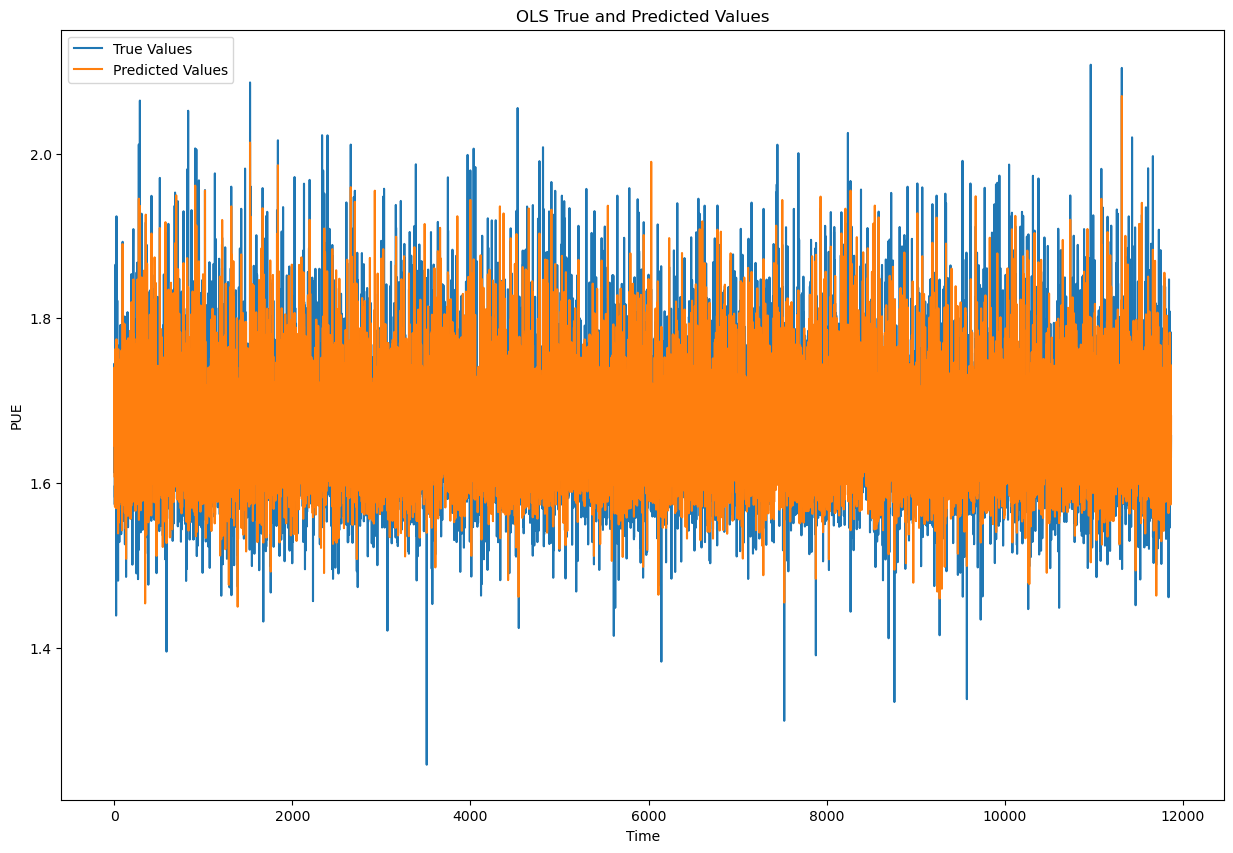

In [15]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

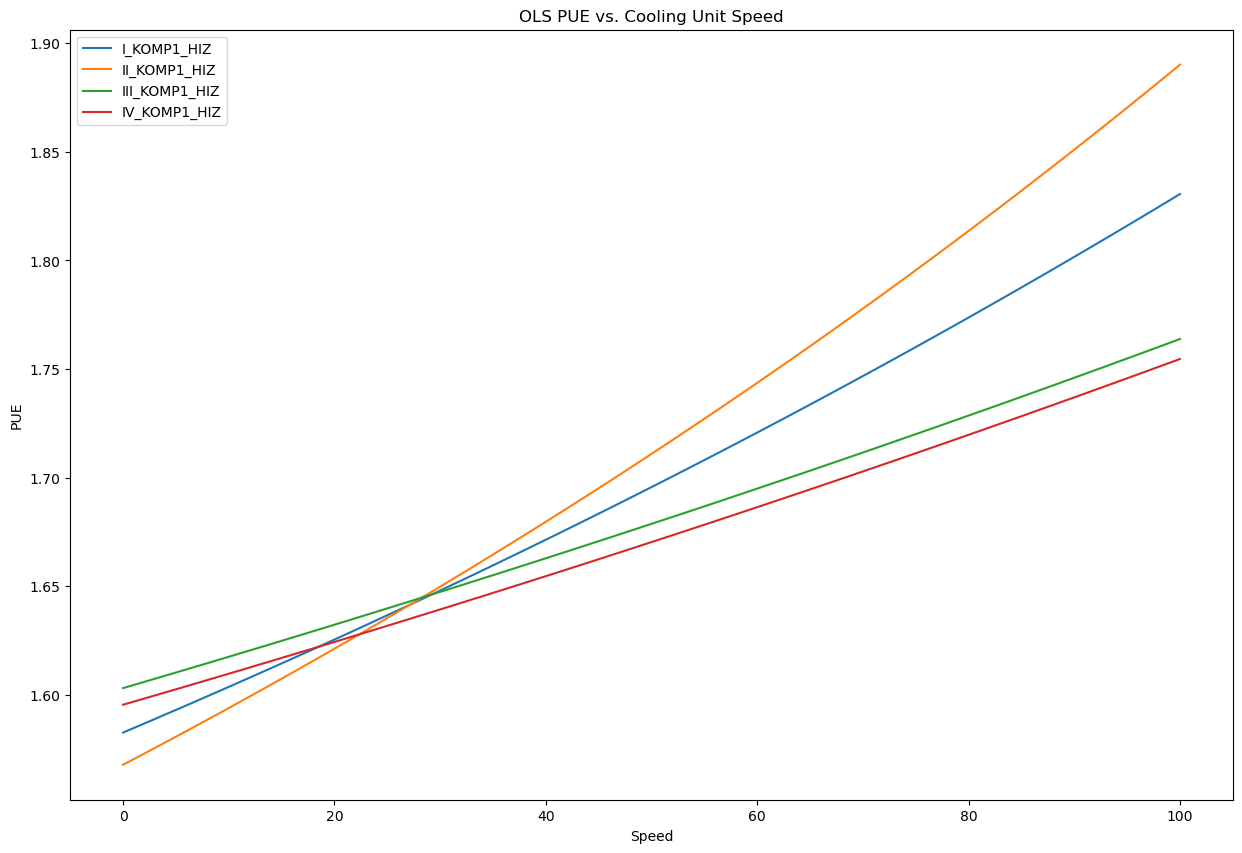

In [16]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[2][i] = y_pred


    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Random Forest

In [17]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [18]:
rf_model = random_forest(max_features='sqrt')

In [19]:
y_pred = np.exp(rf_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.00020097776252222803
MAE Train Set =  0.010125048661858217
RMSE Train Set =  0.014176662601692544
MAPE Train Set =  0.006037970018871372


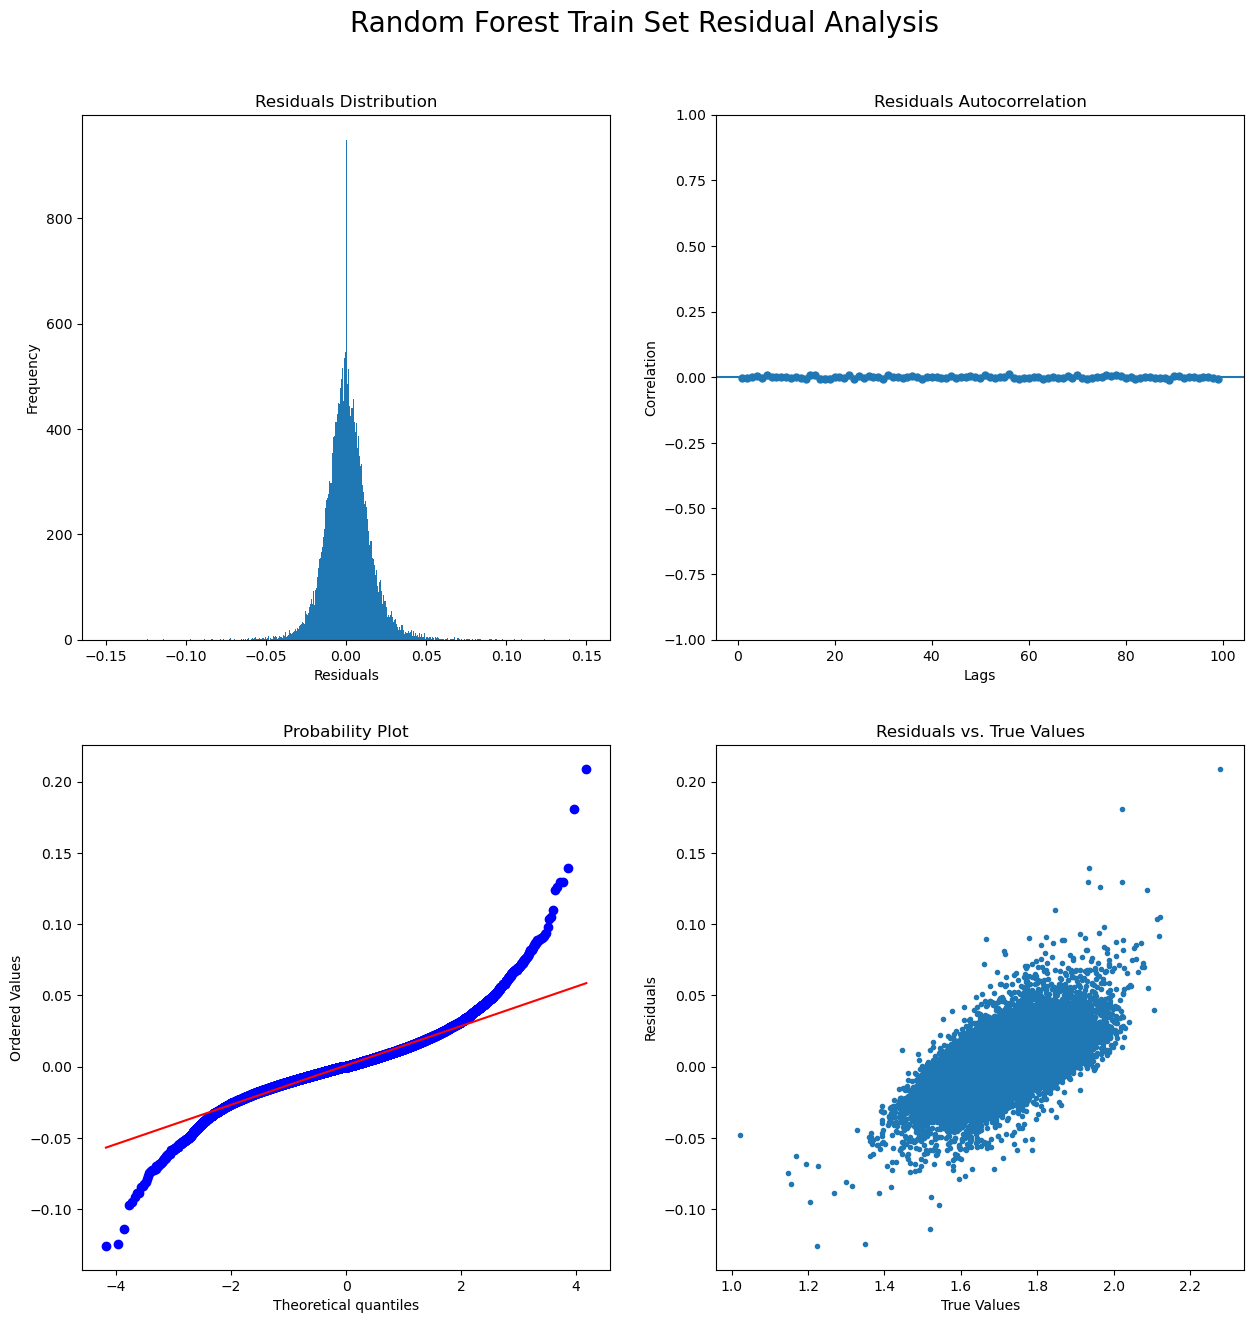

In [20]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.15,0.15))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [21]:
y_pred = np.exp(rf_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.00151074798615216
MAE Test Set =  0.02755891307852895
RMSE Test Set =  0.038868341695423025
MAPE Test Set =  0.01643547174984943


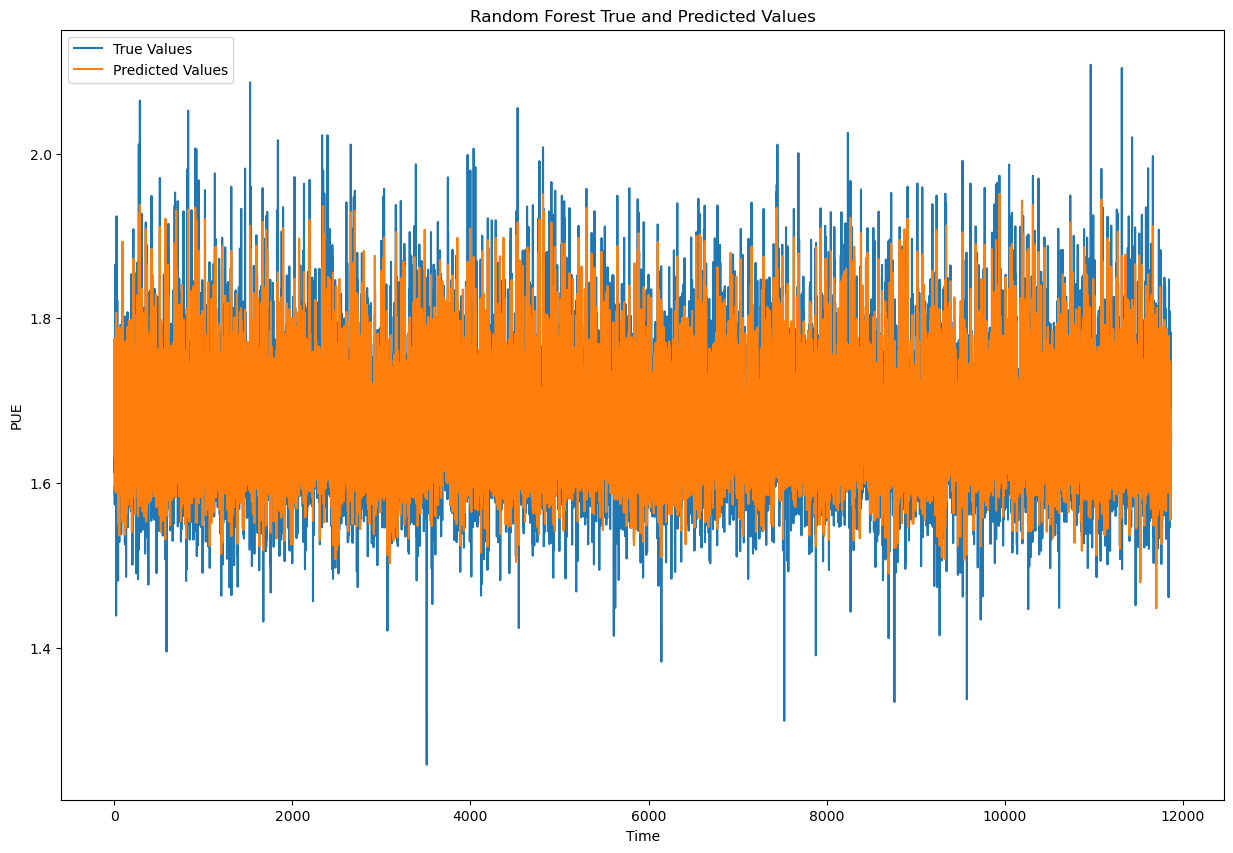

In [22]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

In [23]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

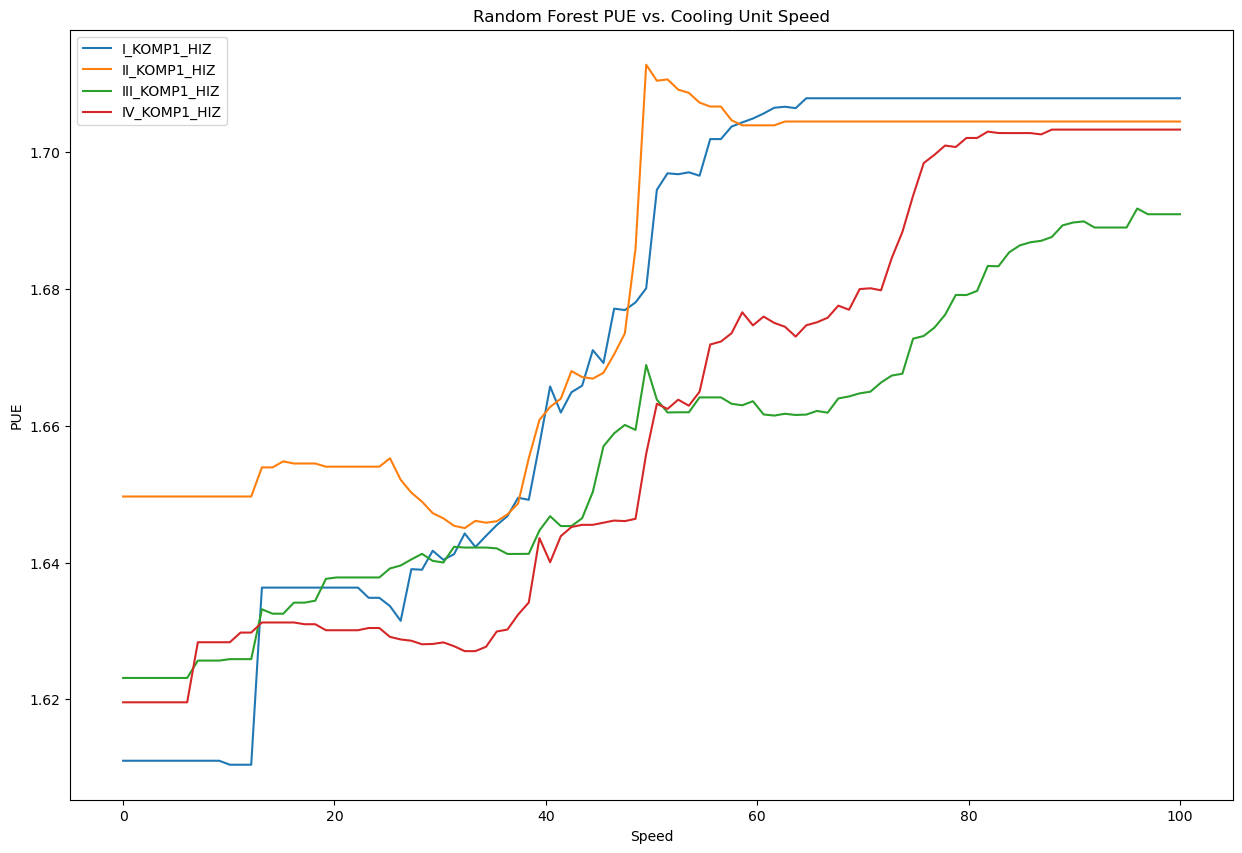

In [24]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Gradient Boosting

In [33]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    gb.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return gb

In [34]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [35]:
with open("PUE_GB.pkl", 'wb') as file:
    pickle.dump(gb_model, file)

In [27]:
y_pred = np.exp(gb_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0010592591225822329
MAE Train Set =  0.023800295290250816
RMSE Train Set =  0.03254626126888053
MAPE Train Set =  0.014232193924259189


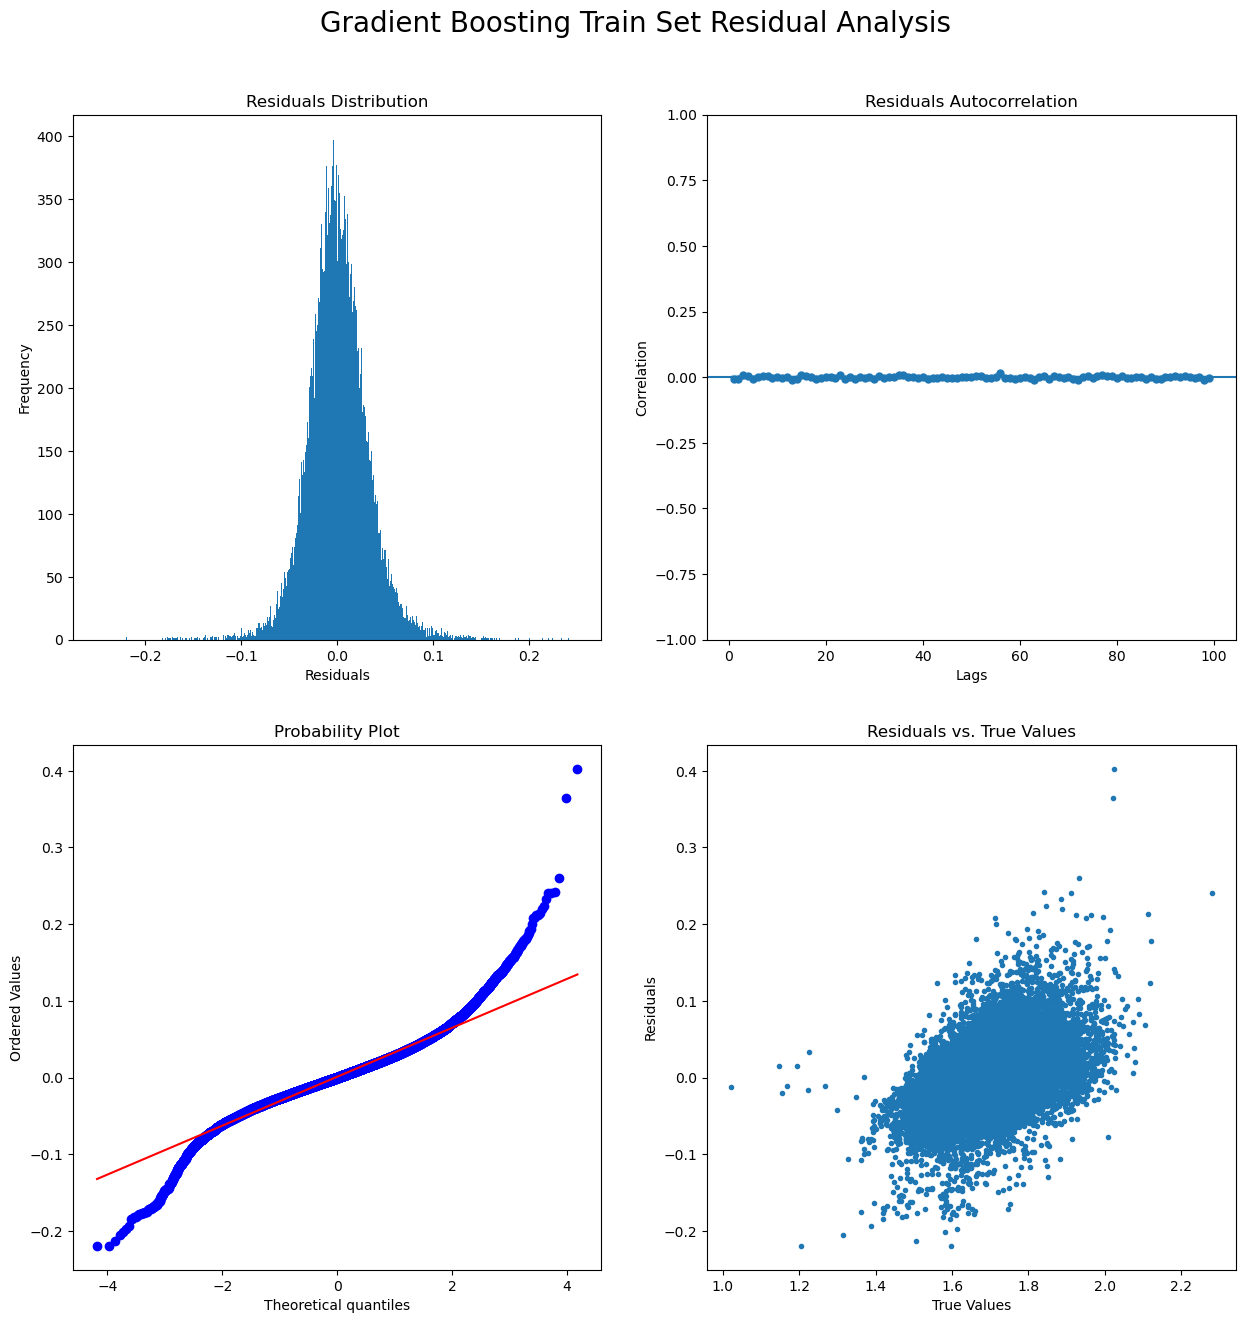

In [28]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [29]:
y_pred = np.exp(gb_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.001293387059568387
MAE Test Set =  0.025318637655433258
RMSE Test Set =  0.035963690850194824
MAPE Test Set =  0.015118176891181258


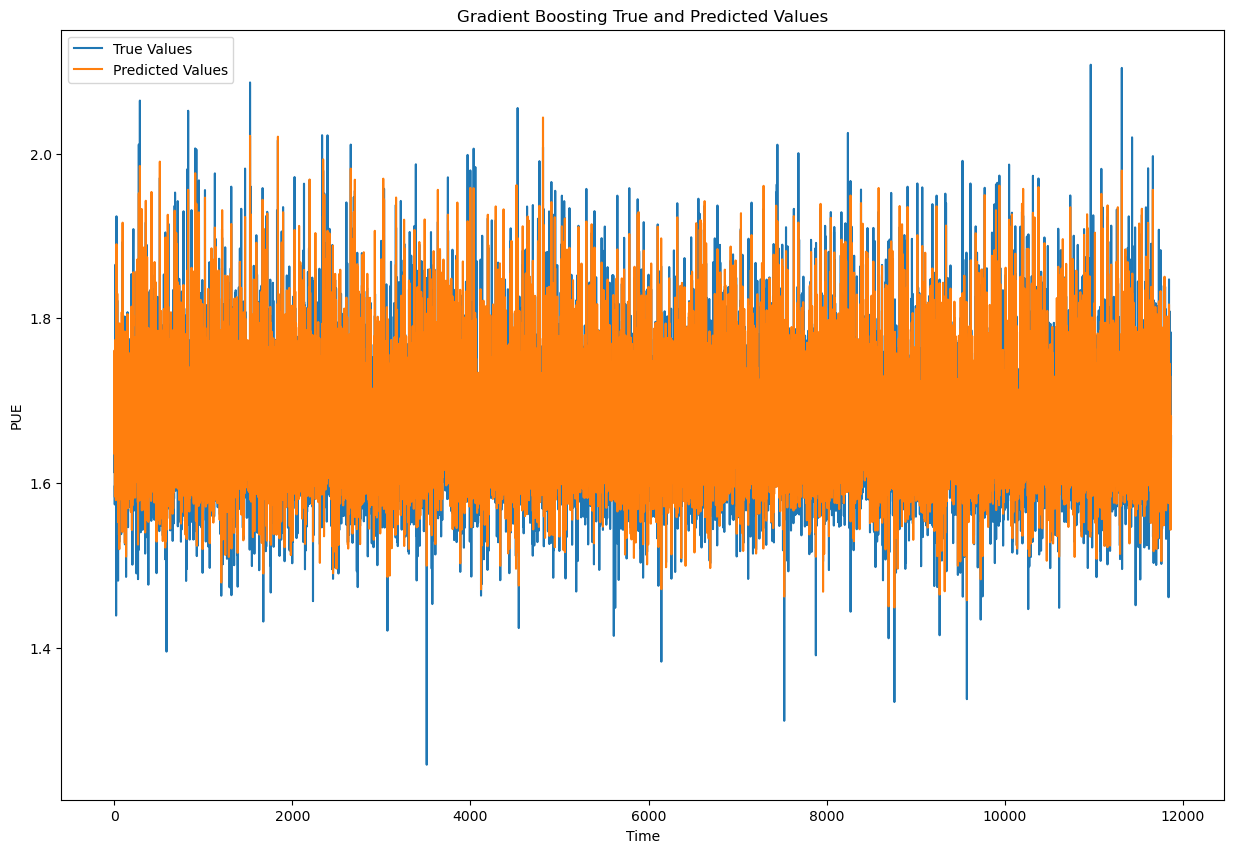

In [30]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

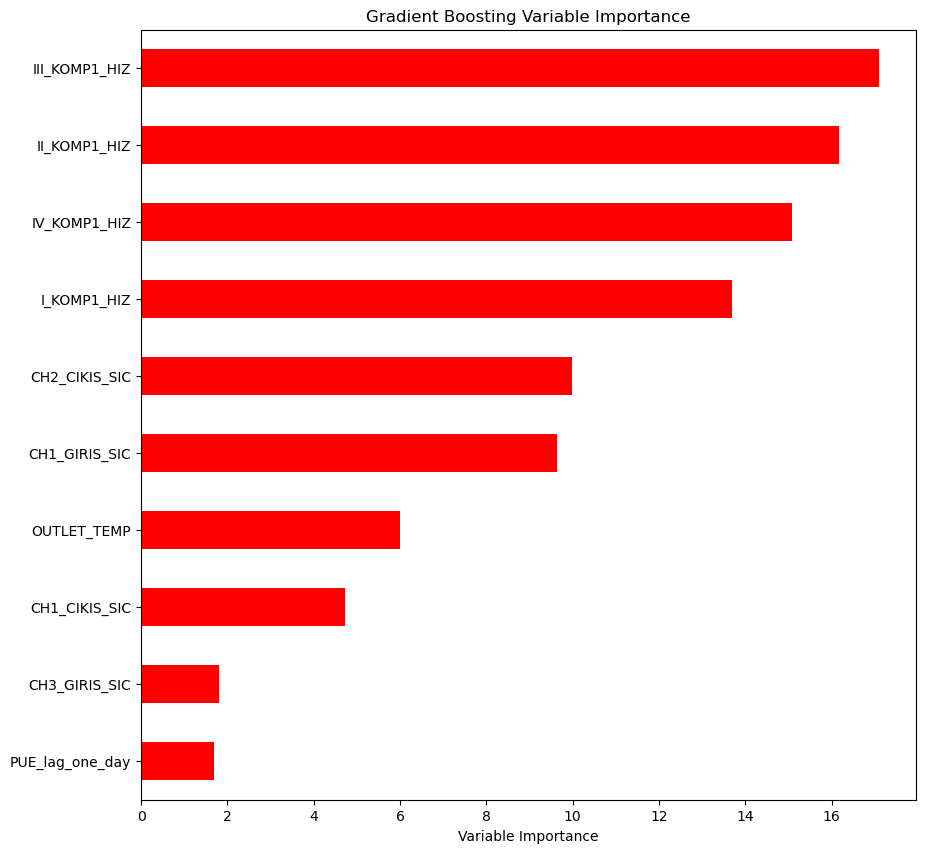

In [31]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

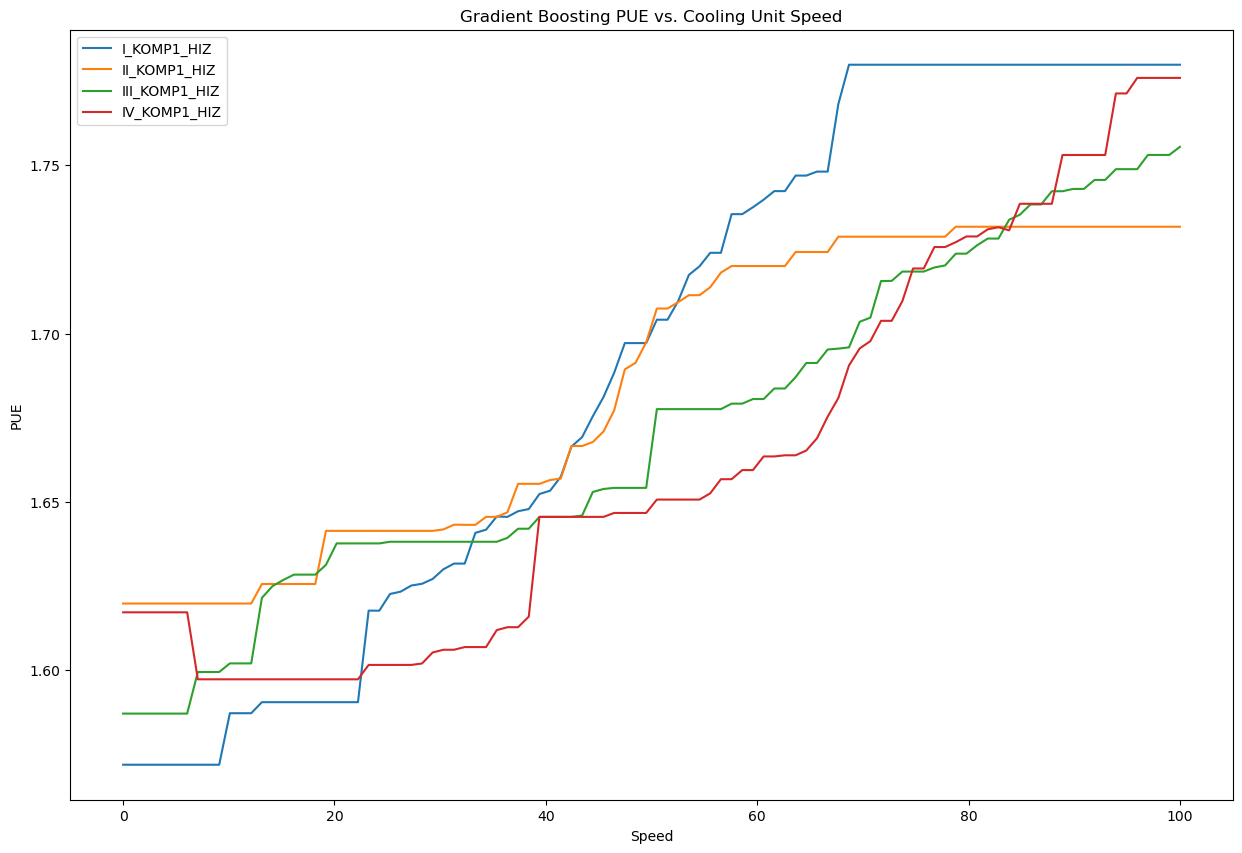

In [32]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Gradient Boosting PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Lasso

In [33]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))  
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [34]:
lasso_model, predictors = lasso(alpha=0.00002)

In [35]:
print(train.iloc[:,list(predictors+2)].columns)

Index(['I_KOMP1_HIZ', 'II_KOMP1_HIZ', 'III_KOMP1_HIZ', 'IV_KOMP1_HIZ',
       'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC', 'CH2_CIKIS_SIC', 'CH3_GIRIS_SIC',
       'SENSOR_I_TEMP', 'OUTLET_TEMP', 'OUTLET_HUMIDITY', 'month_4', 'month_5',
       'month_7', 'month_8', 'month_10', 'PUE_lag_one_day'],
      dtype='object')


In [36]:
y_pred = np.exp(lasso_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0032090030276251636
MAE Train Set =  0.04195321545867014
RMSE Train Set =  0.05664806287619342
MAPE Train Set =  0.02488336417639788


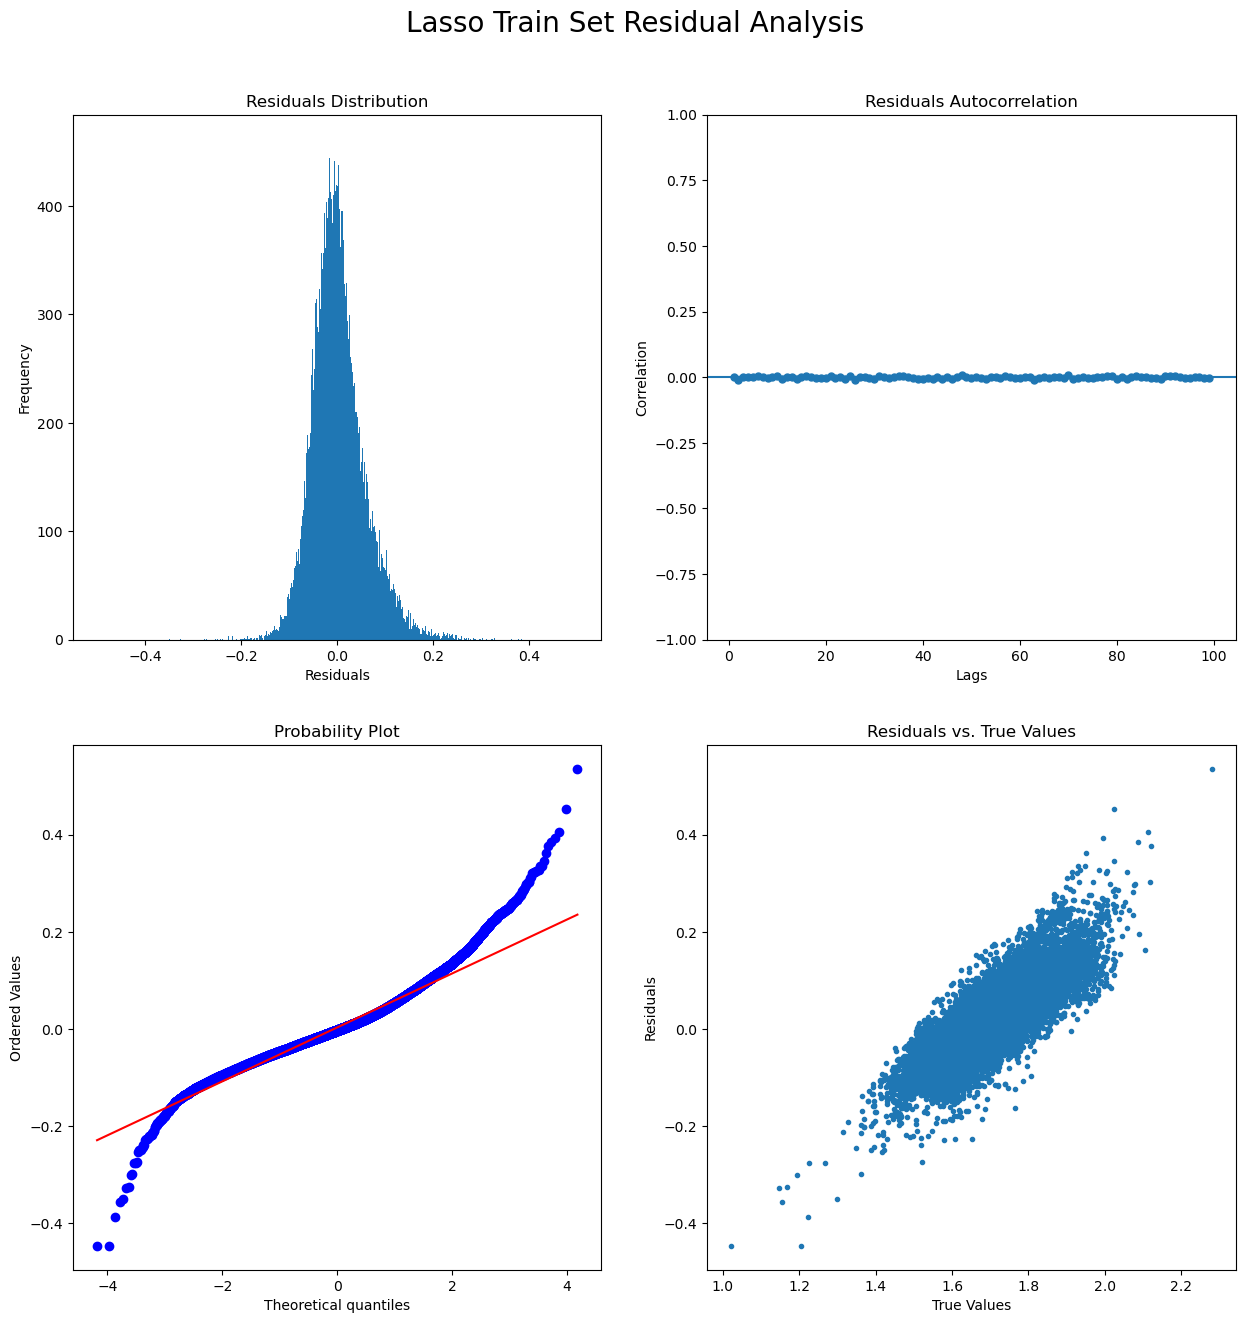

In [37]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [38]:
y_pred = np.exp(lasso_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.003267523057381515
MAE Test Set =  0.04232328082515997
RMSE Test Set =  0.0571622520321017
MAPE Test Set =  0.02506457009823681


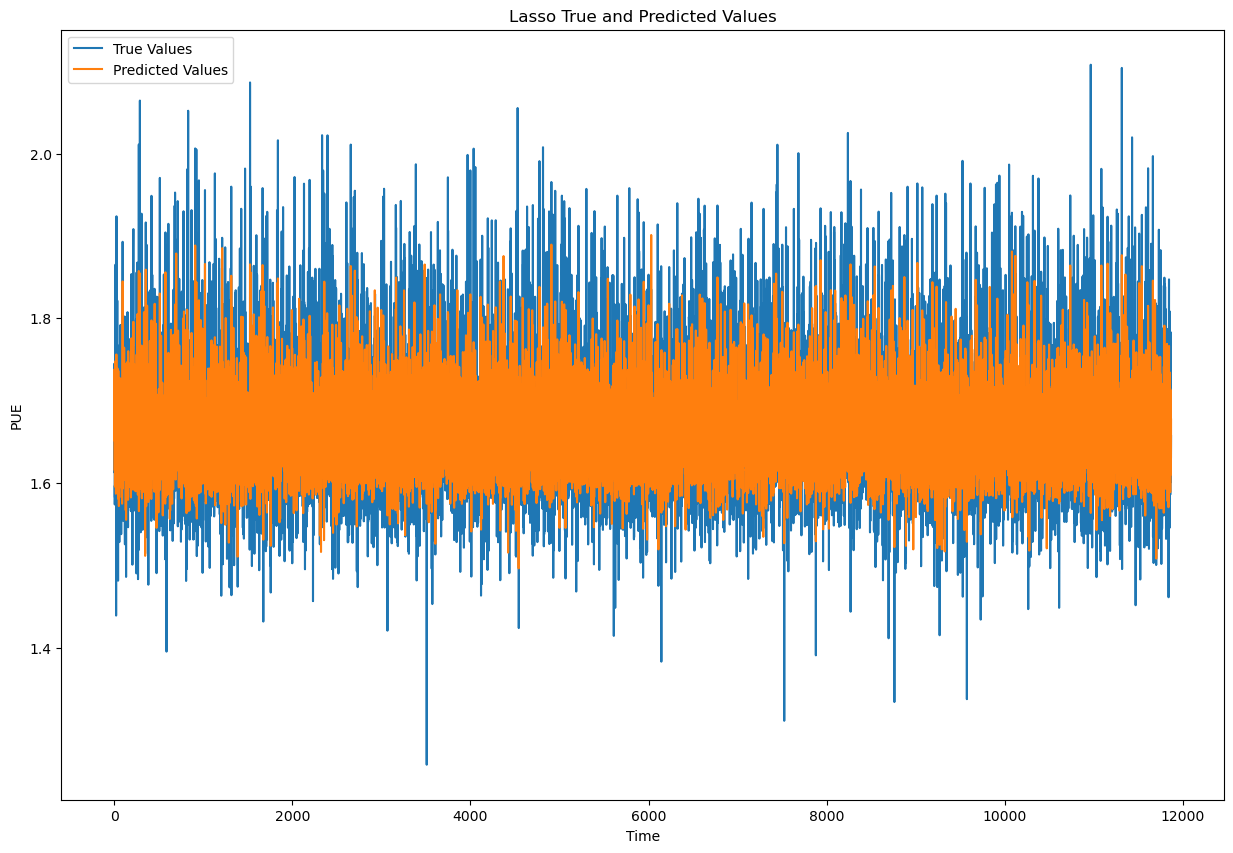

In [39]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

# Sensor-I Temperature Predictions

## OLS

In [155]:
formula_x1 = "np.log(SENSOR_I_TEMP)"
formula_x2 = "np.log(SENSOR_II_TEMP)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    if FINAL_DF.columns[i] != 'SENSOR_I_TEMP' and FINAL_DF.columns[i] != 'SENSOR_II_TEMP' and FINAL_DF.columns[i] != 'PUE_lag_one_day':
    #if FINAL_DF.columns[i] != 'SENSOR_I_TEMP' and FINAL_DF.columns[i] != 'SENSOR_II_TEMP' and FINAL_DF.columns[i] != 'PUE_lag_one_day' and "month" not in FINAL_DF.columns[i] and len(FINAL_DF.columns[i]) != 3 and "hour" not in FINAL_DF.columns[i]:
        formula_y += FINAL_DF.columns[i] + " + "

formula_y = formula_y[:-3]

formula1 = formula_x1 + " ~ " + formula_y
formula2 = formula_x2 + " ~ " + formula_y
print(formula1)
print(formula2)

np.log(SENSOR_I_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + KS10_UDP_TUKETIM + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10
np.log(SENSOR_II_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + KS10_UDP_TUKETIM + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_1

In [157]:
reg_model = sm.ols(formula=formula1, data=train).fit()
reg_model.save("SENSOR_I_OLS.pkl")
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(SENSOR_I_TEMP)   R-squared:                       0.818
Model:                               OLS   Adj. R-squared:                  0.818
Method:                    Least Squares   F-statistic:                     4443.
Date:                   Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                           21:33:15   Log-Likelihood:                 93400.
No. Observations:                  47472   AIC:                        -1.867e+05
Df Residuals:                      47423   BIC:                        -1.863e+05
Df Model:                             48                                         
Covariance Type:               nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.8274      0.010    186.583      0.000       1.808       1.847
I_KOMP1_HIZ          0.0001   1.66e-05      7.437      0.000    9.09e-05       0.000
II_KOMP1_HIZ     -3.481e-06   1.52e-05     -0.229      0.819   -3.33e-05    2.63e-05
III_KOMP1_HIZ    -3.687e-05   9.89e-06     -3.730      0.000   -5.63e-05   -1.75e-05
IV_KOMP1_HIZ         0.0001   1.28e-05     11.433      0.000       0.000       0.000
KS10_UDP_TUKETIM     0.0008      0.000      6.050      0.000       0.001       0.001
CH1_CIKIS_SIC       -0.0007      0.000     -3.535      0.000      -0.001      -0.000
CH1_GIRIS_SIC        0.0047      0.000     21.262      0.000       0.004       0.005
CH2_CIKIS_SIC       -0.0015   6.91e-05    -21.776      0.000      -0.002      -0.001
CH2_GIRIS_SIC       -0.0001   1.65e-05     -6.565      0.000      -0.000    -7.6e-05
CH3_CIKIS_SIC       -0.0425      0.000   -192.879      0.000      -0.043      -0.042
CH3_GIRIS_SIC        0.0456      0.001     85.923      0.000       0.045       0.047
OUTLET_TEMP         -0.0333      0.000   -111.328      0.000      -0.034      -0.033
OUTLET_HUMIDITY      0.0807      0.001    126.262      0.000       0.079       0.082
Mon                  0.0020      0.000      4.571      0.000       0.001       0.003
Tue                 -0.0005      0.000     -1.059      0.290      -0.001       0.000
Wed               8.829e-05      0.000      0.203      0.839      -0.001       0.001
Thu                 -0.0002      0.000     -0.559      0.576      -0.001       0.001
Fri                 -0.0018      0.000     -4.128      0.000      -0.003      -0.001
Sat                 -0.0025      0.000     -5.671      0.000      -0.003      -0.002
hour_0               0.0013      0.001      1.584      0.113      -0.000       0.003
hour_1               0.0026      0.001      3.110      0.002       0.001       0.004
hour_2               0.0035      0.001      4.167      0.000       0.002       0.005
hour_3               0.0030      0.001      3.534      0.000       0.001       0.005
hour_4               0.0027      0.001      3.325      0.001       0.001       0.004
hour_5               0.0055      0.001      6.623      0.000       0.004       0.007
hour_6               0.0045      0.001      5.507      0.000       0.003       0.006
hour_7               0.0056      0.001      6.975      0.000       0.004       0.007
hour_8               0.0061      0.001      7.347      0.000       0.004       0.008
hour_9               0.0022      0.001      2.624      0.009       0.001       0.004
hour_10              0.0011      0.001      1.346      0.178      -0.001       0.003
hour_11             -0.0038      0.001     -4.458      0.000      -0.005      -0.002
hour_12             -0.0055      0.001     -6.549      0.000      -0.007   

In [42]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.500831278977621
MAE Train Set =  0.5447272681095556
RMSE Train Set =  0.7076943400774243
MAPE Train Set =  0.030996380209143134


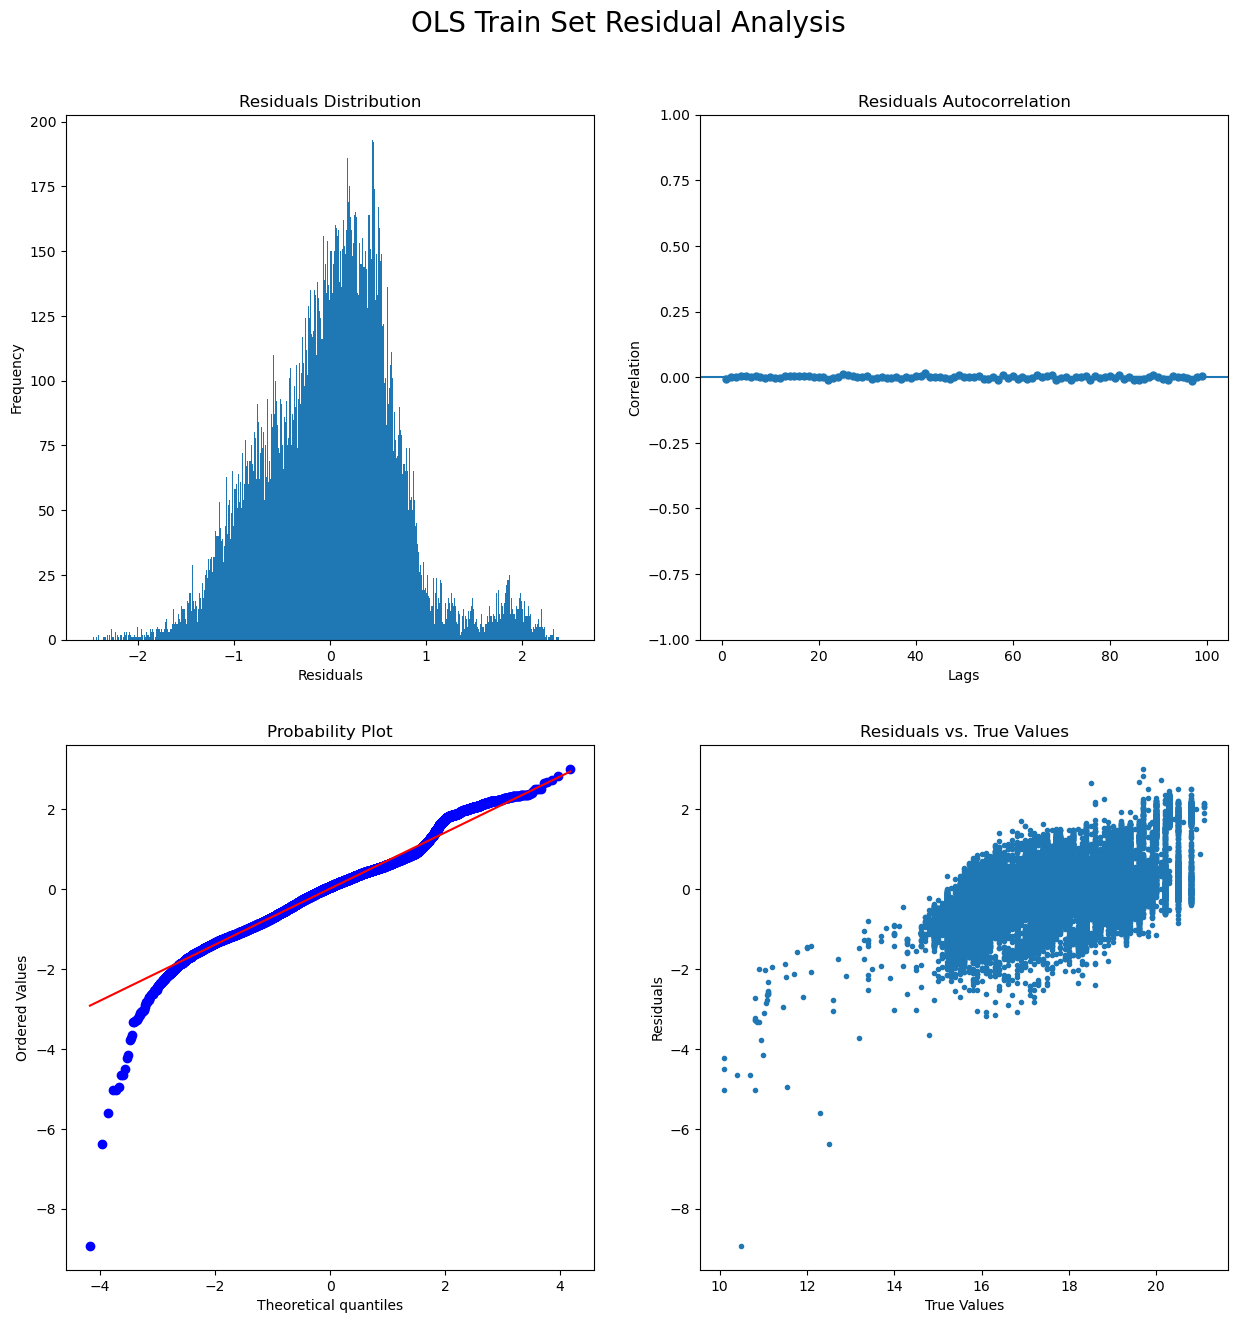

In [43]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [44]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.5015043295618045
MAE Test Set =  0.5434797666670842
RMSE Test Set =  0.7081697039282353
MAPE Test Set =  0.030945619956912775


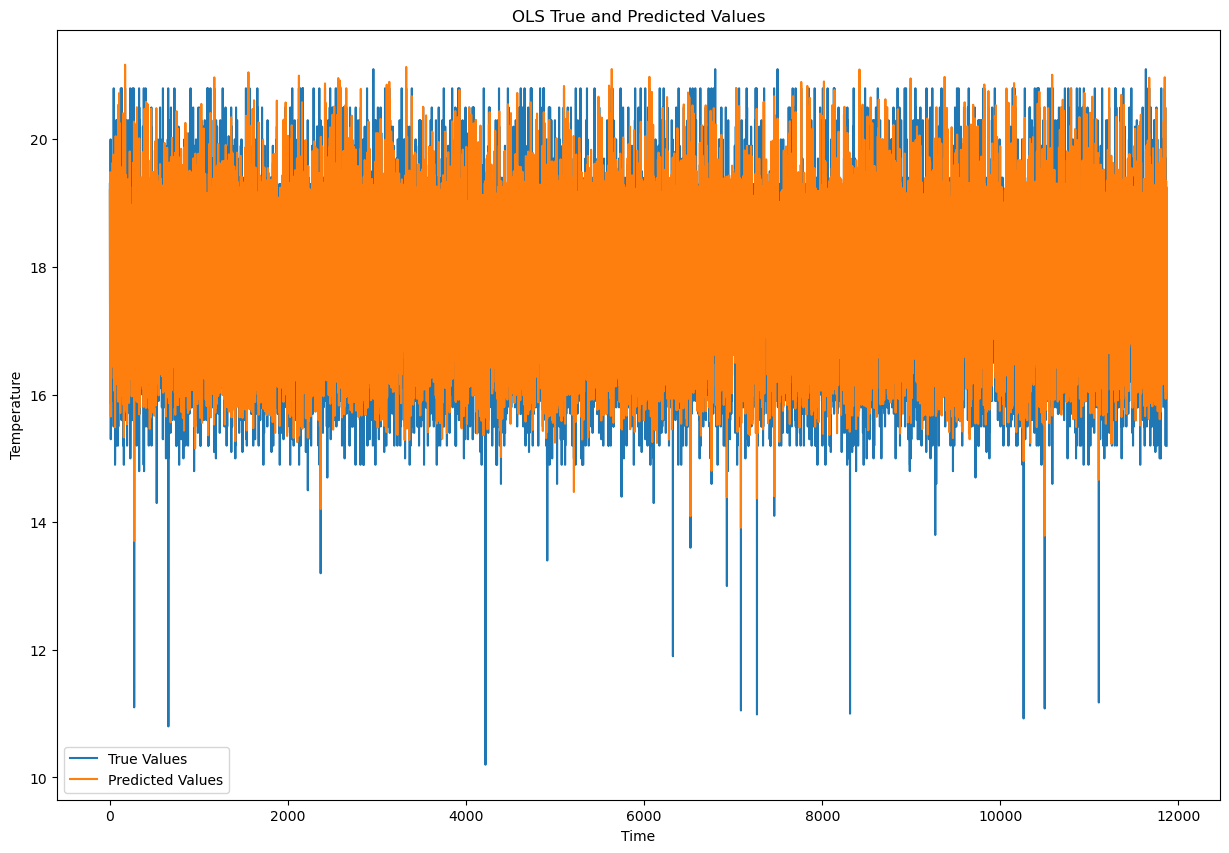

In [45]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

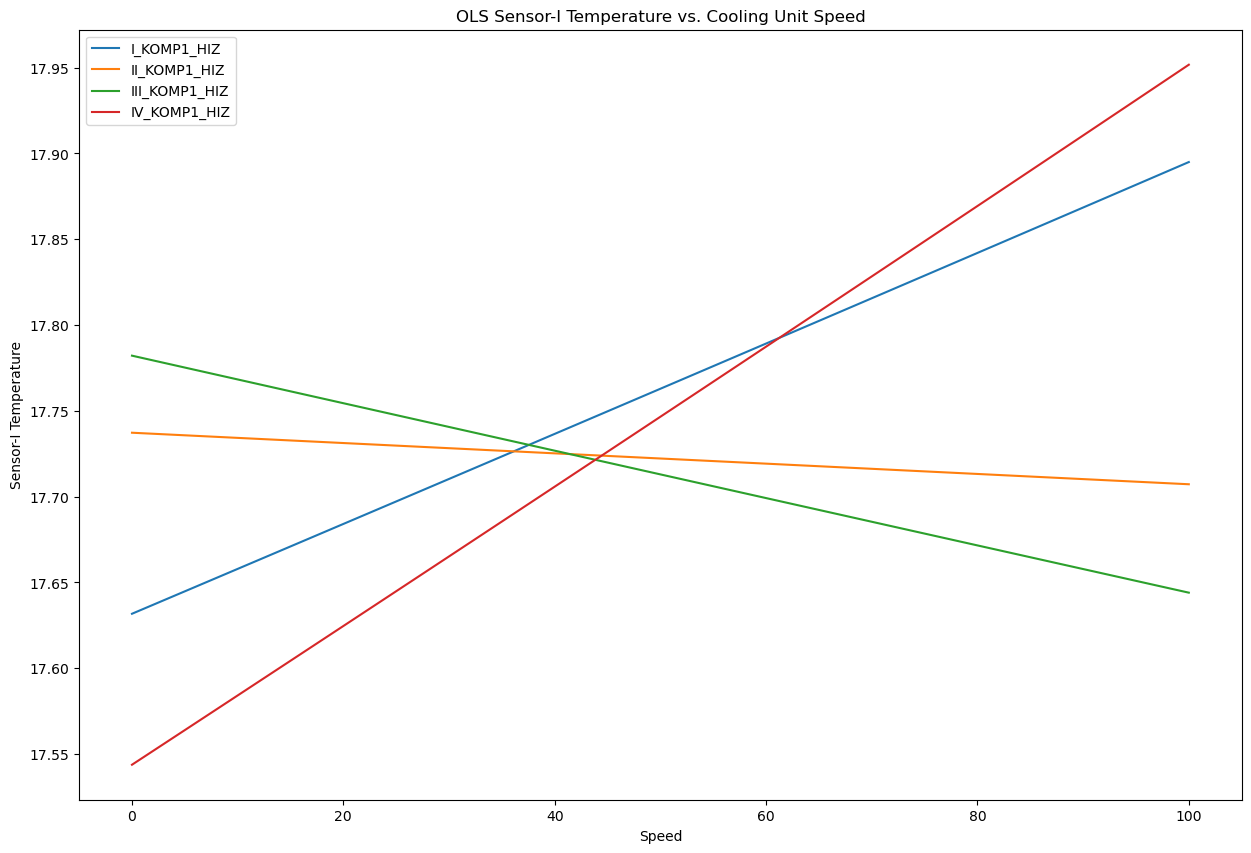

In [46]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('OLS Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Random Forest

In [27]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return random_forest

In [28]:
rf_model = random_forest(max_features='sqrt')

In [29]:
with open("SensorI-RF.pkl", 'wb') as file:
    pickle.dump(rf_model, file)

In [49]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.012147478781166699
MAE Train Set =  0.05989708767824964
RMSE Train Set =  0.11021560135101881
MAPE Train Set =  0.003458911948935282


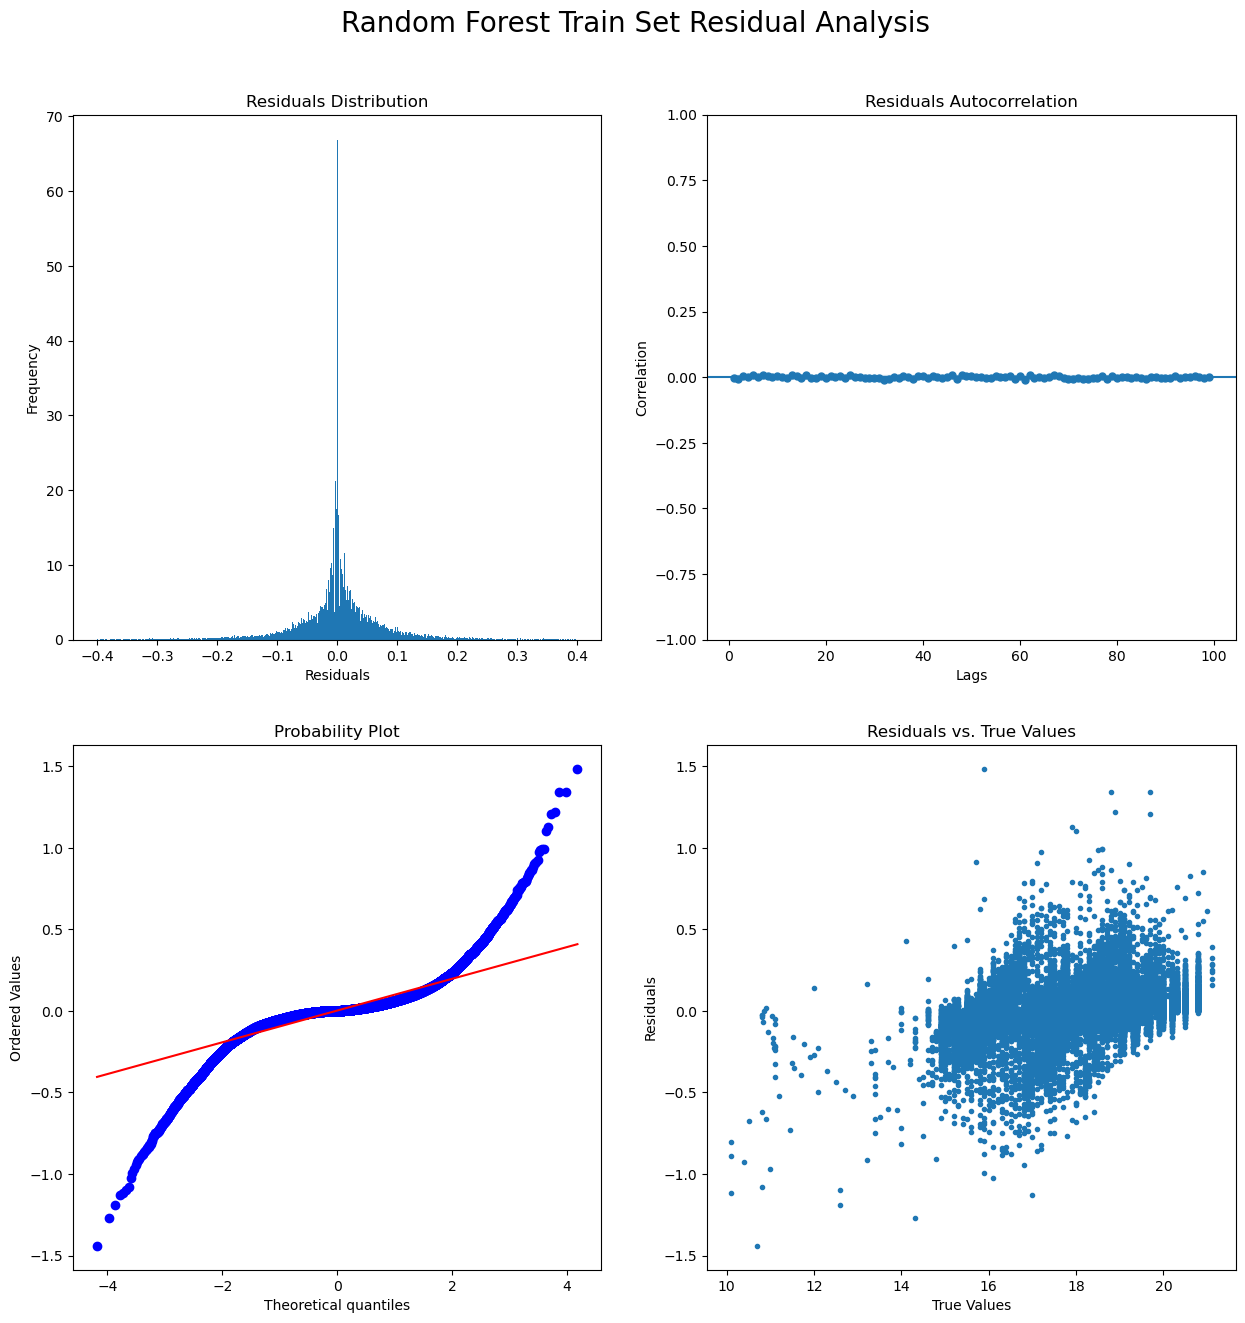

In [50]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.4,0.4), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [51]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.08836070398400149
MAE Test Set =  0.15961841659638162
RMSE Test Set =  0.2972552841986186
MAPE Test Set =  0.009273225263916713


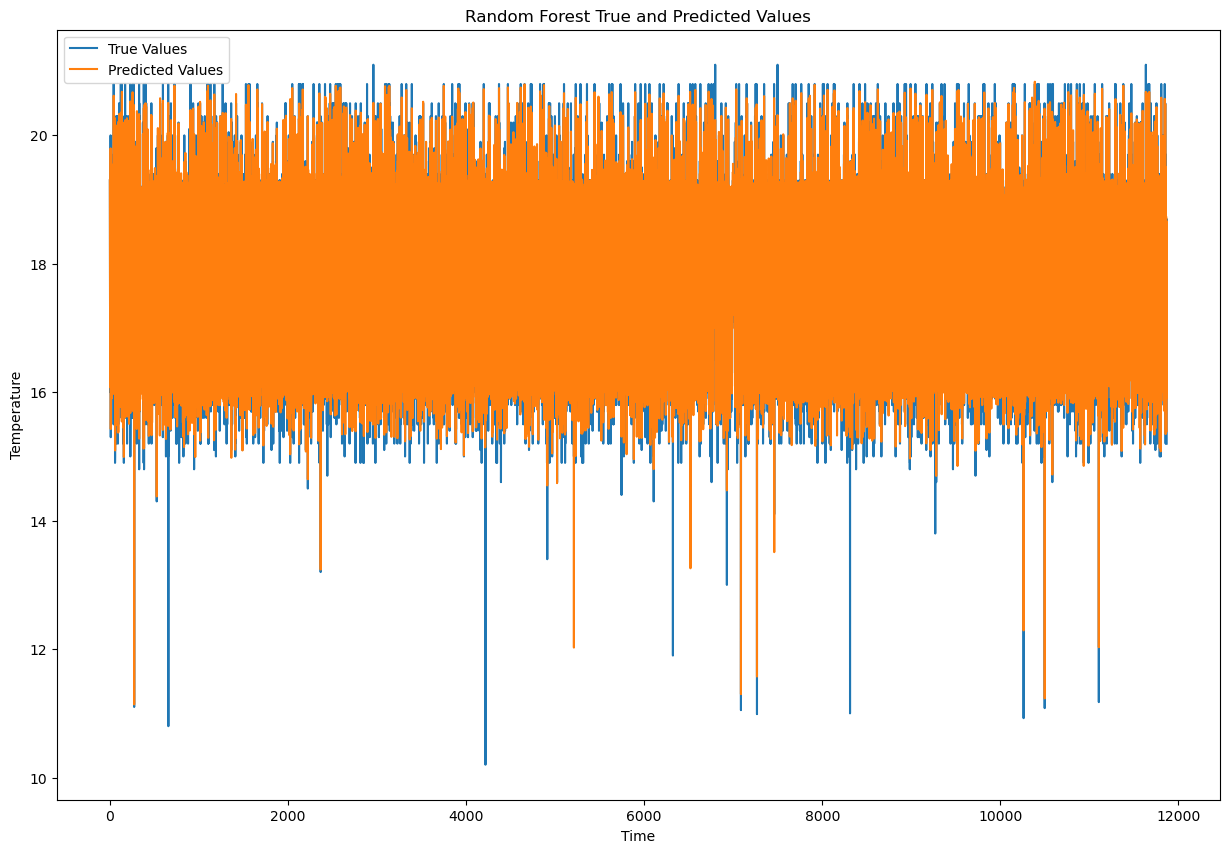

In [52]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

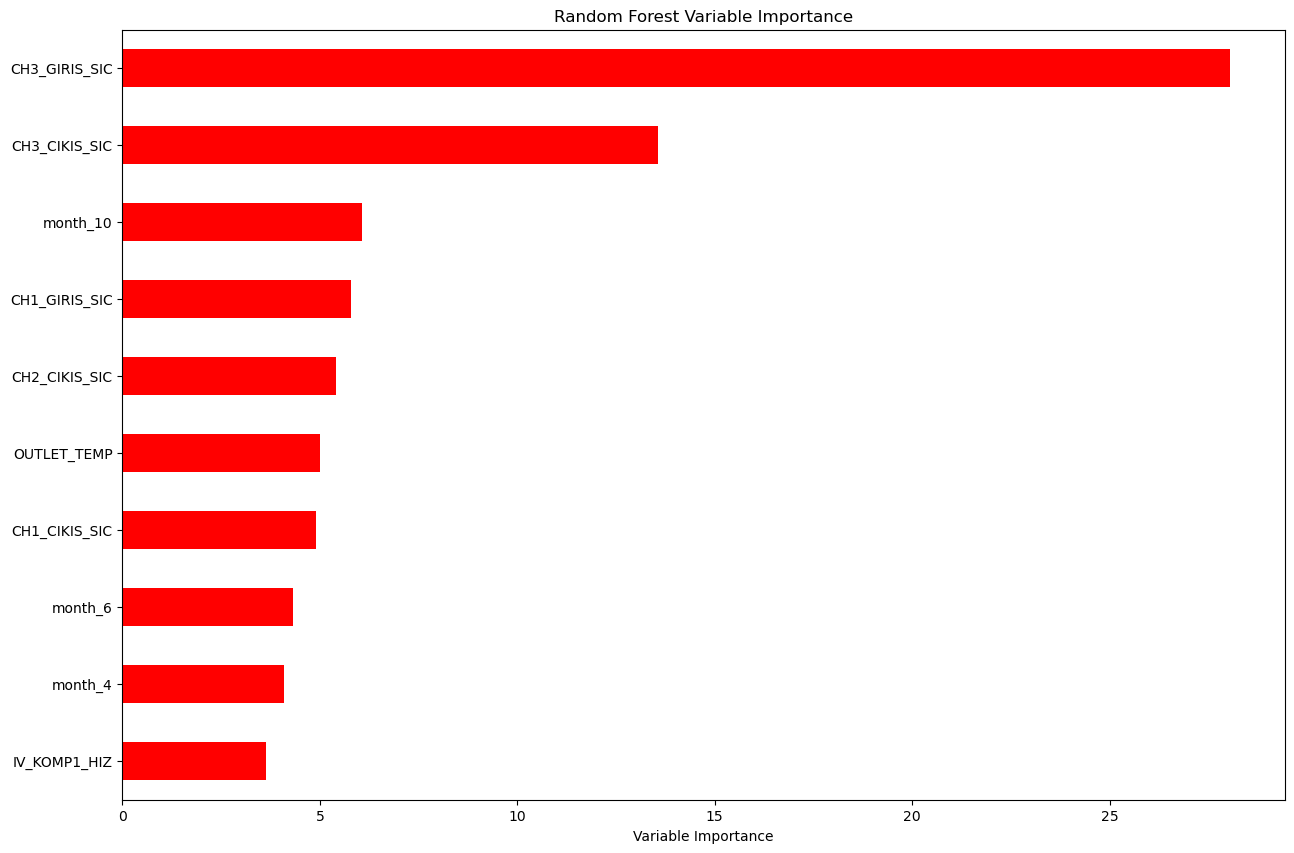

In [53]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

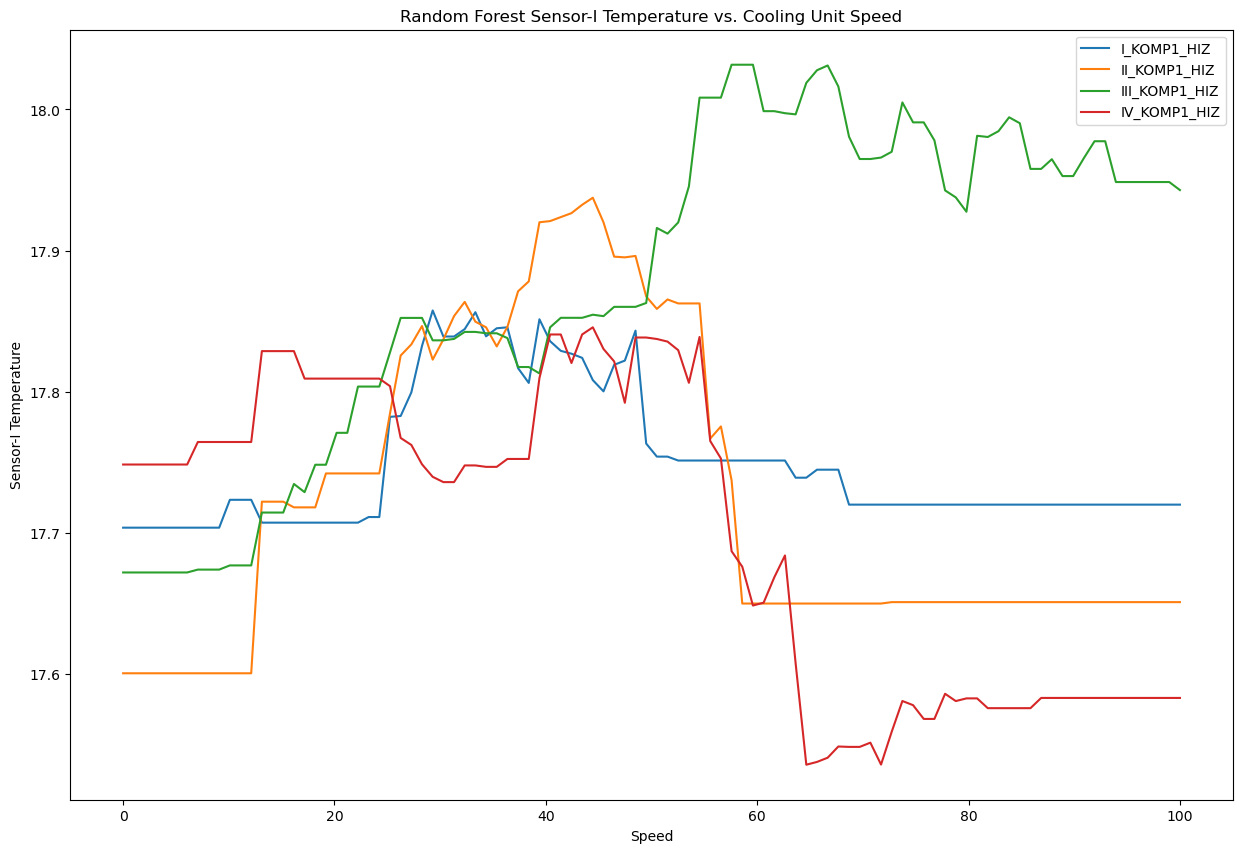

In [54]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [55]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return result

In [56]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [57]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.11471775885836491
MAE Train Set =  0.21203861365069598
RMSE Train Set =  0.33870010165095155
MAPE Train Set =  0.012101873439394707


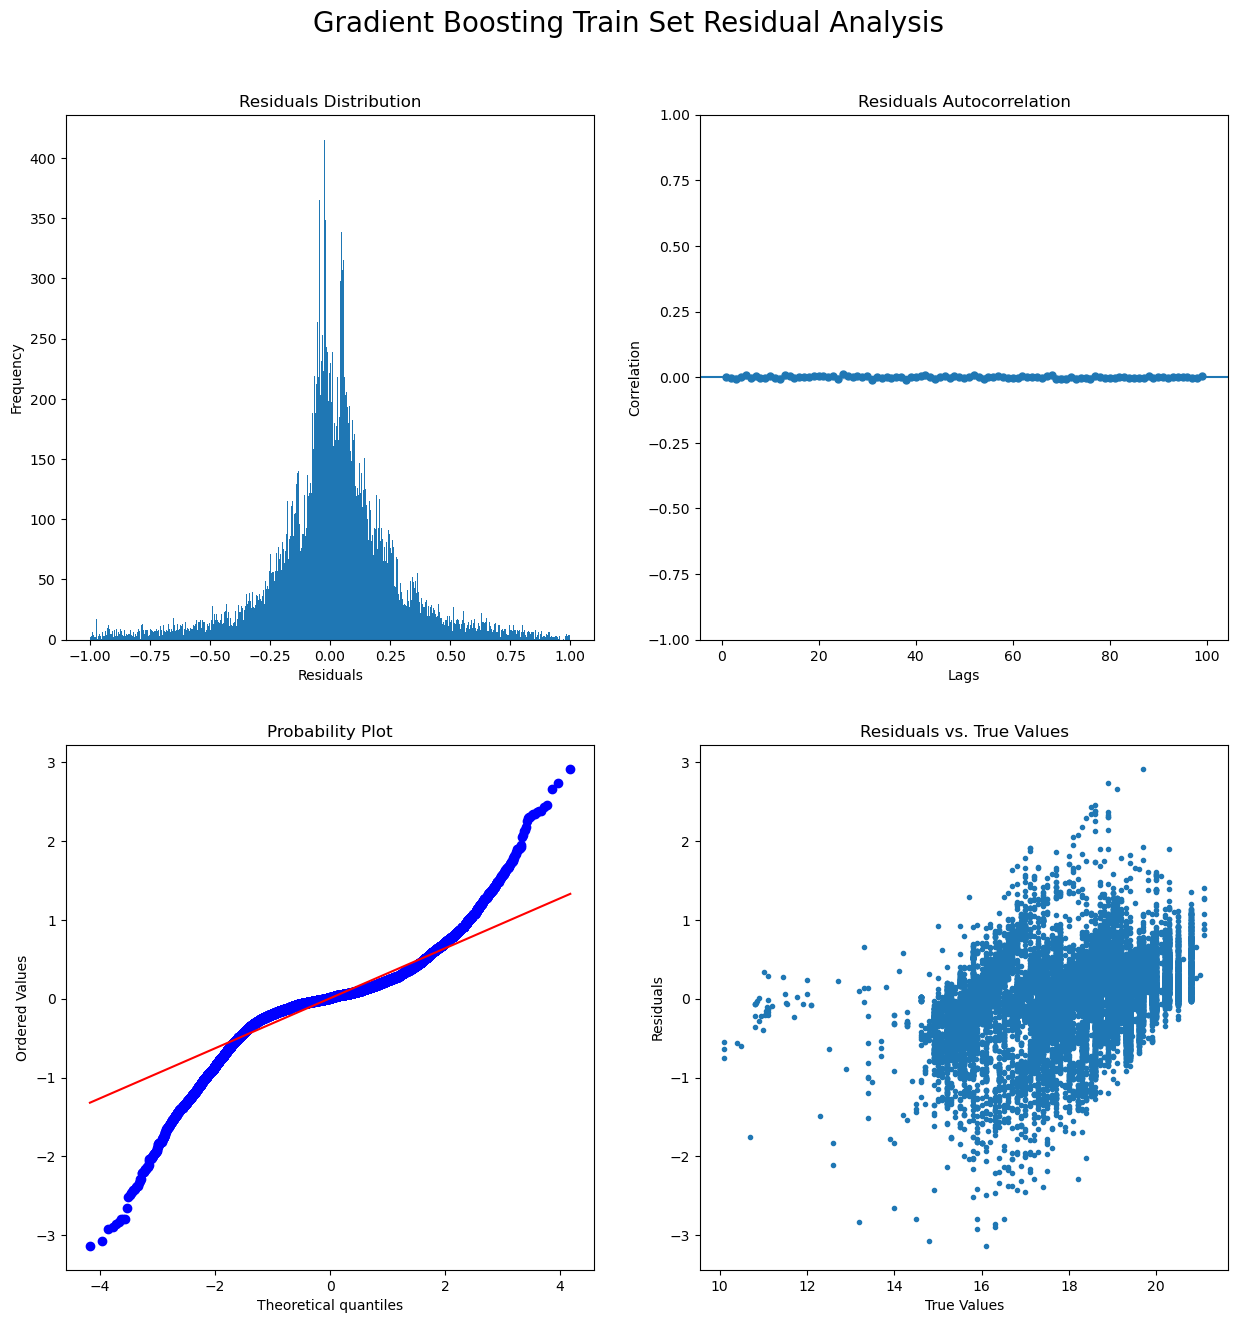

In [58]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-1,1))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [59]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.1346432972090613
MAE Test Set =  0.21959628031445413
RMSE Test Set =  0.36693772933436714
MAPE Test Set =  0.01259567054711481


In [60]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [61]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

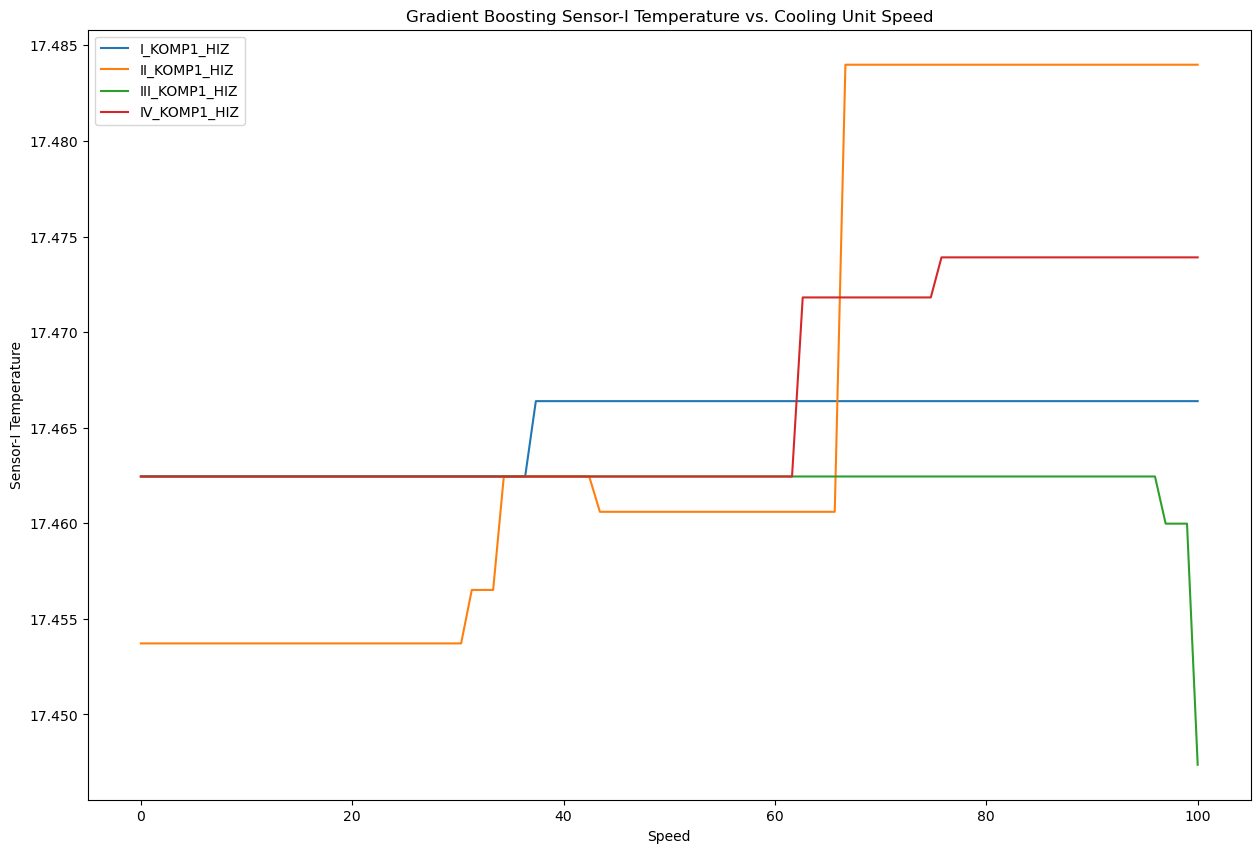

In [62]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Lasso

In [63]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [64]:
lasso_model, predictors = lasso(alpha=0.00002)

In [65]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['CH1_GIRIS_SIC', 'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC', 'OUTLET_HUMIDITY',
       'month_4', 'month_5', 'month_7', 'month_9', 'month_10'],
      dtype='object')


In [66]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.5641939258545674
MAE Test Set =  0.57299145298584
RMSE Test Set =  0.7511284349926898
MAPE Test Set =  0.03281485687885142


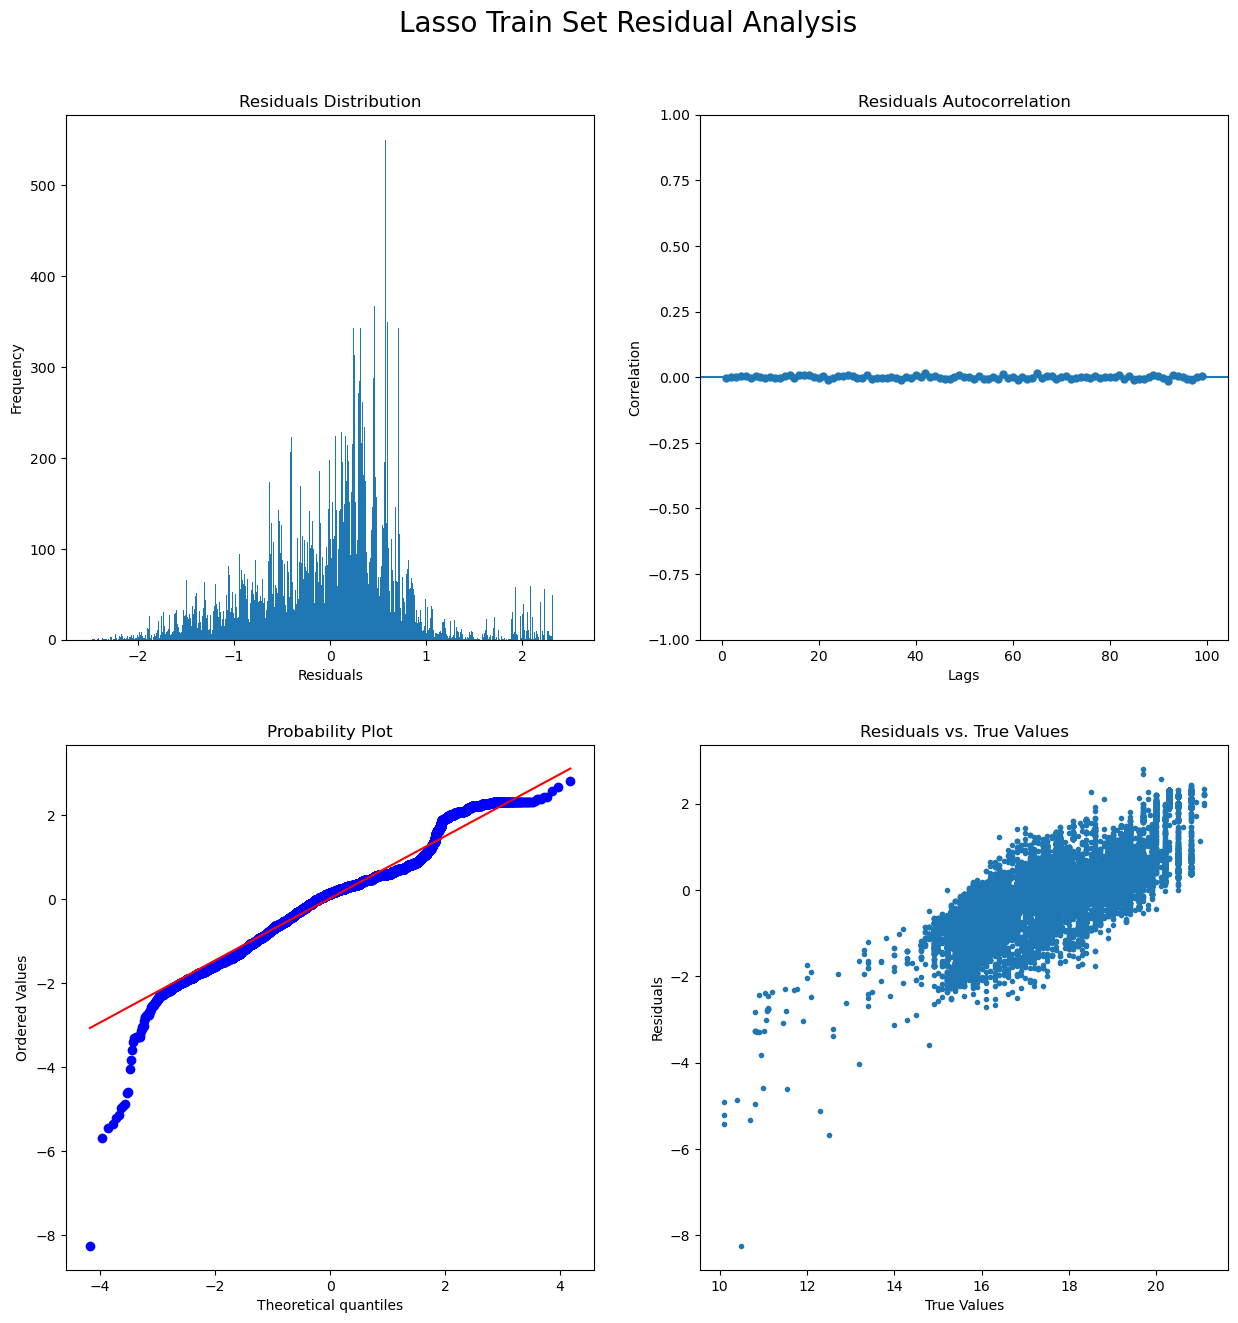

In [67]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [68]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.5659634965576099
MAE Test Set =  0.5731390031211369
RMSE Test Set =  0.7523054542920781
MAPE Test Set =  0.032835926983309706


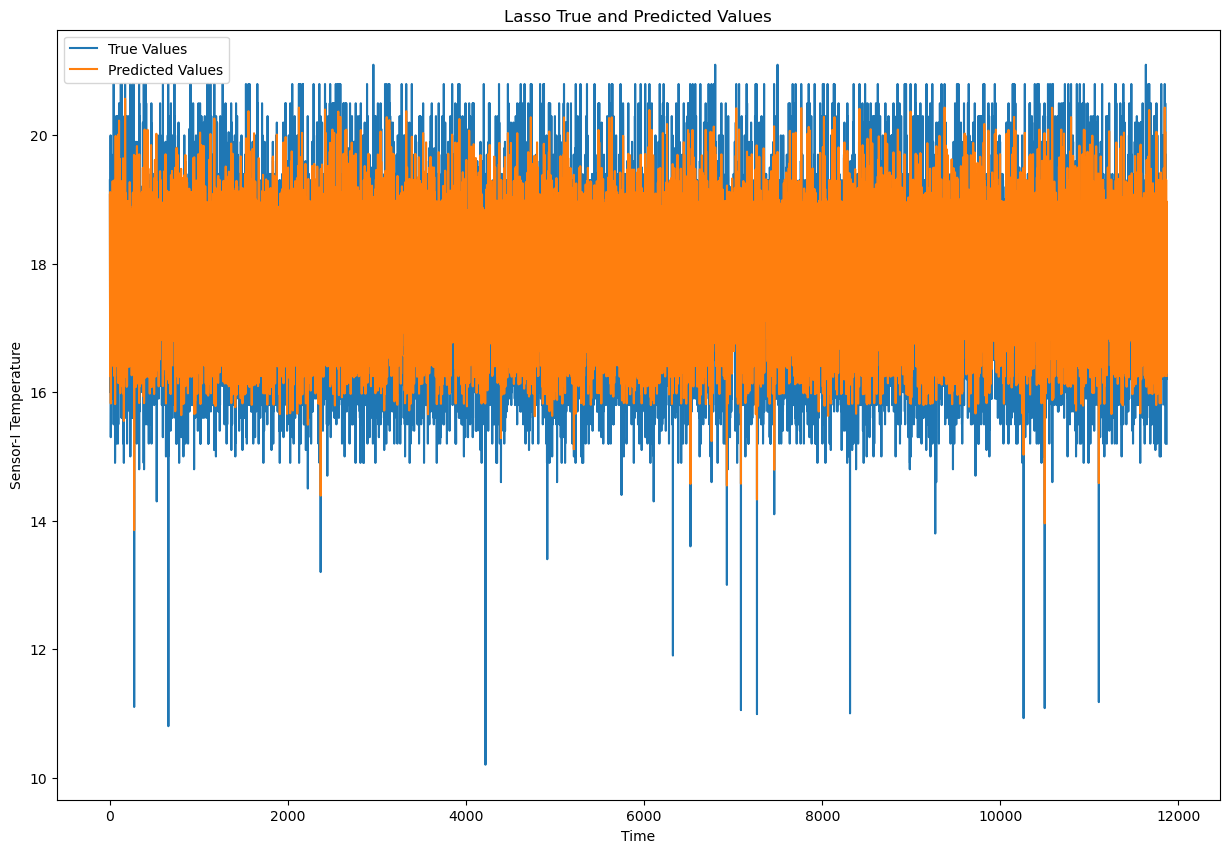

In [69]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

# Sensor-II Temperature Predictions

## OLS

In [158]:
reg_model = sm.ols(formula=formula2, data=train).fit()
reg_model.save("SENSOR_II_OLS.pkl")
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(SENSOR_II_TEMP)   R-squared:                       0.907
Model:                                OLS   Adj. R-squared:                  0.907
Method:                     Least Squares   F-statistic:                     9616.
Date:                    Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                            21:33:19   Log-Likelihood:             1.2733e+05
No. Observations:                   47472   AIC:                        -2.546e+05
Df Residuals:                       47423   BIC:                        -2.541e+05
Df Model:                              48                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7602      0.005    367.305      0.000       1.751       1.770
I_KOMP1_HIZ      -6.512e-06   8.12e-06     -0.802      0.422   -2.24e-05     9.4e-06
II_KOMP1_HIZ     -3.697e-06   7.44e-06     -0.497      0.619   -1.83e-05    1.09e-05
III_KOMP1_HIZ     1.997e-06   4.84e-06      0.413      0.680   -7.49e-06    1.15e-05
IV_KOMP1_HIZ     -6.699e-05   6.26e-06    -10.703      0.000   -7.93e-05   -5.47e-05
KS10_UDP_TUKETIM     0.0011   6.24e-05     17.970      0.000       0.001       0.001
CH1_CIKIS_SIC        0.0012      0.000     11.916      0.000       0.001       0.001
CH1_GIRIS_SIC        0.0012      0.000     11.147      0.000       0.001       0.001
CH2_CIKIS_SIC        0.0012   3.38e-05     36.910      0.000       0.001       0.001
CH2_GIRIS_SIC        0.0002   8.07e-06     19.206      0.000       0.000       0.000
CH3_CIKIS_SIC       -0.0009      0.000     -8.442      0.000      -0.001      -0.001
CH3_GIRIS_SIC        0.0172      0.000     66.358      0.000       0.017       0.018
OUTLET_TEMP          0.0008      0.000      5.515      0.000       0.001       0.001
OUTLET_HUMIDITY      0.0414      0.000    132.482      0.000       0.041       0.042
Mon                  0.0004      0.000      1.850      0.064   -2.31e-05       0.001
Tue                  0.0023      0.000     11.207      0.000       0.002       0.003
Wed                  0.0011      0.000      5.219      0.000       0.001       0.002
Thu               9.157e-05      0.000      0.431      0.666      -0.000       0.001
Fri                 -0.0005      0.000     -2.353      0.019      -0.001   -8.33e-05
Sat                  0.0004      0.000      1.653      0.098   -6.52e-05       0.001
hour_0               0.0019      0.000      4.628      0.000       0.001       0.003
hour_1               0.0023      0.000      5.656      0.000       0.002       0.003
hour_2               0.0023      0.000      5.650      0.000       0.002       0.003
hour_3               0.0020      0.000      4.917      0.000       0.001       0.003
hour_4               0.0012      0.000      2.930      0.003       0.000       0.002
hour_5               0.0014      0.000      3.544      0.000       0.001       0.002
hour_6               0.0003      0.000      0.834      0.404      -0.000       0.001
hour_7              -0.0003      0.000     -0.773      0.439      -0.001       0.000
hour_8              -0.0001      0.000     -0.362      0.717      -0.001       0.001
hour_9               0.0012      0.000      2.990      0.003       0.000       0.002
hour_10              0.0002      0.000      0.410      0.682      -0.001       0.001
hour_11             -0.0019      0.000     -4.516      0.000      -0.003      -0.001
hour_12             -0.0025      0.000     -6.099      0.000    

In [71]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.15800429745528088
MAE Train Set =  0.21419315267040548
RMSE Train Set =  0.3974975439613192
MAPE Train Set =  0.011295817929012046


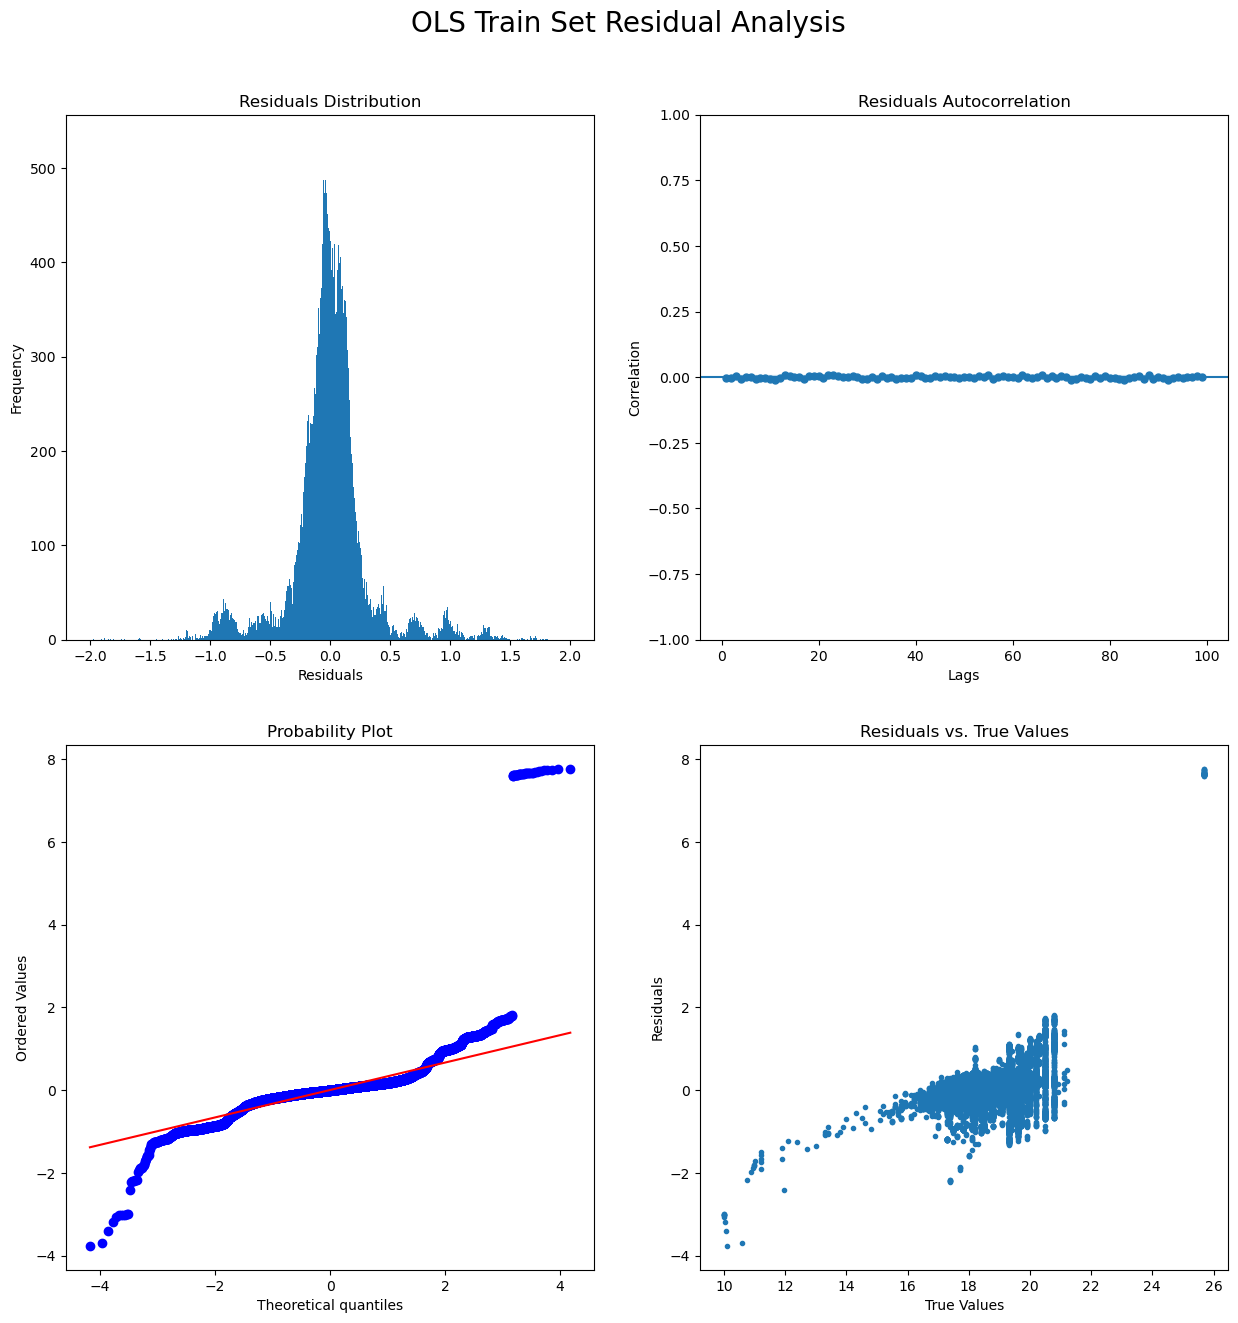

In [72]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2,2))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [73]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.152261745686158
MAE Test Set =  0.21361772777851287
RMSE Test Set =  0.3902073111644091
MAPE Test Set =  0.011265561926975582


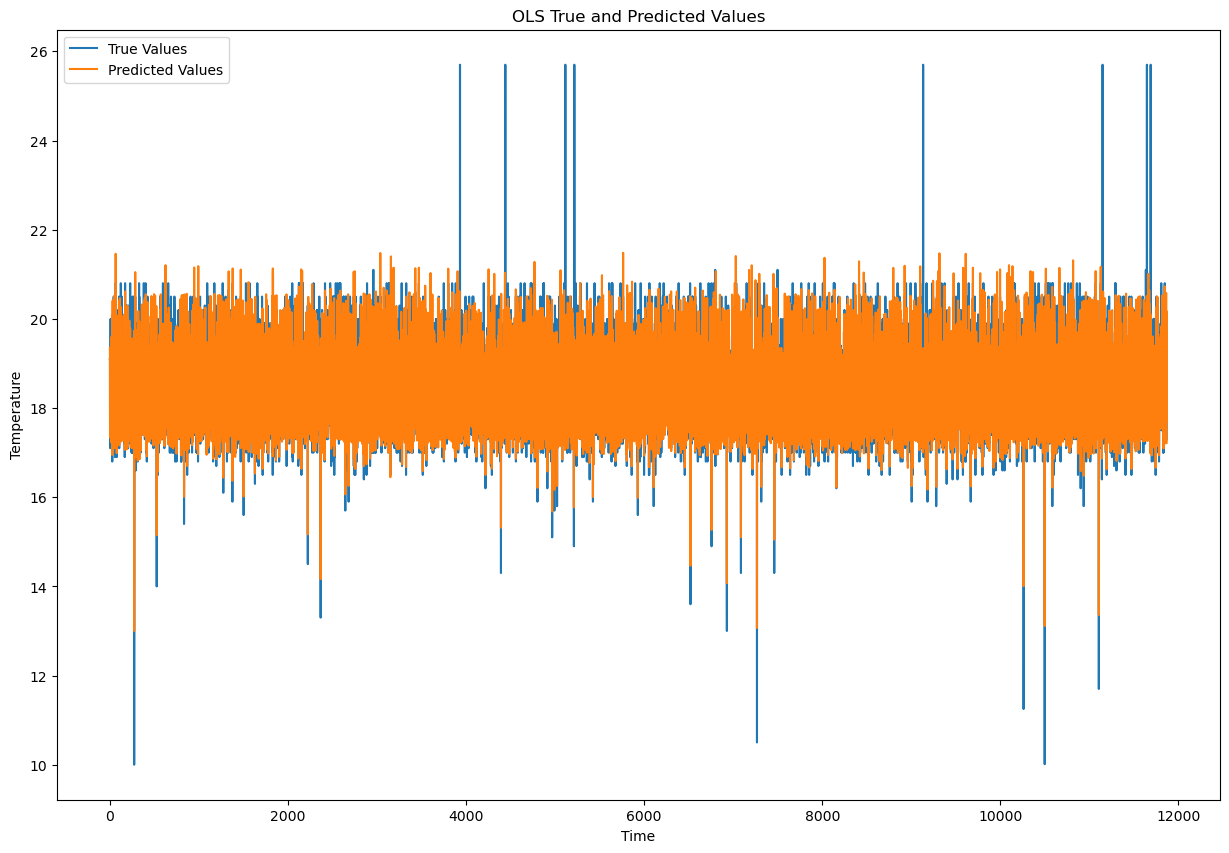

In [74]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

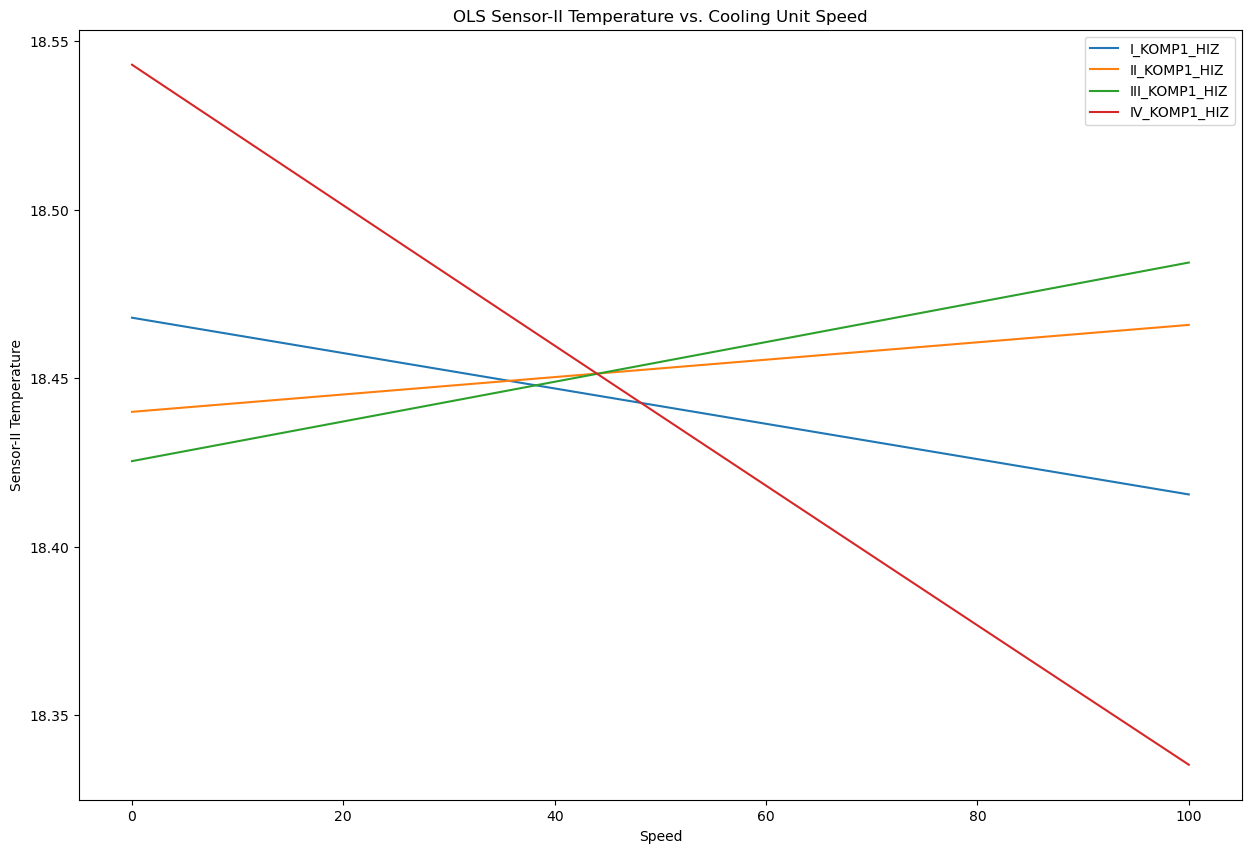

In [75]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Random Forest

In [30]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return random_forest

In [31]:
rf_model = random_forest(max_features='sqrt')

In [32]:
with open("SensorII-RF.pkl", 'wb') as file:
    pickle.dump(rf_model, file)

In [78]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0029347905983882856
MAE Train Set =  0.03203507806224182
RMSE Train Set =  0.054173707630069824
MAPE Train Set =  0.001730402037007118


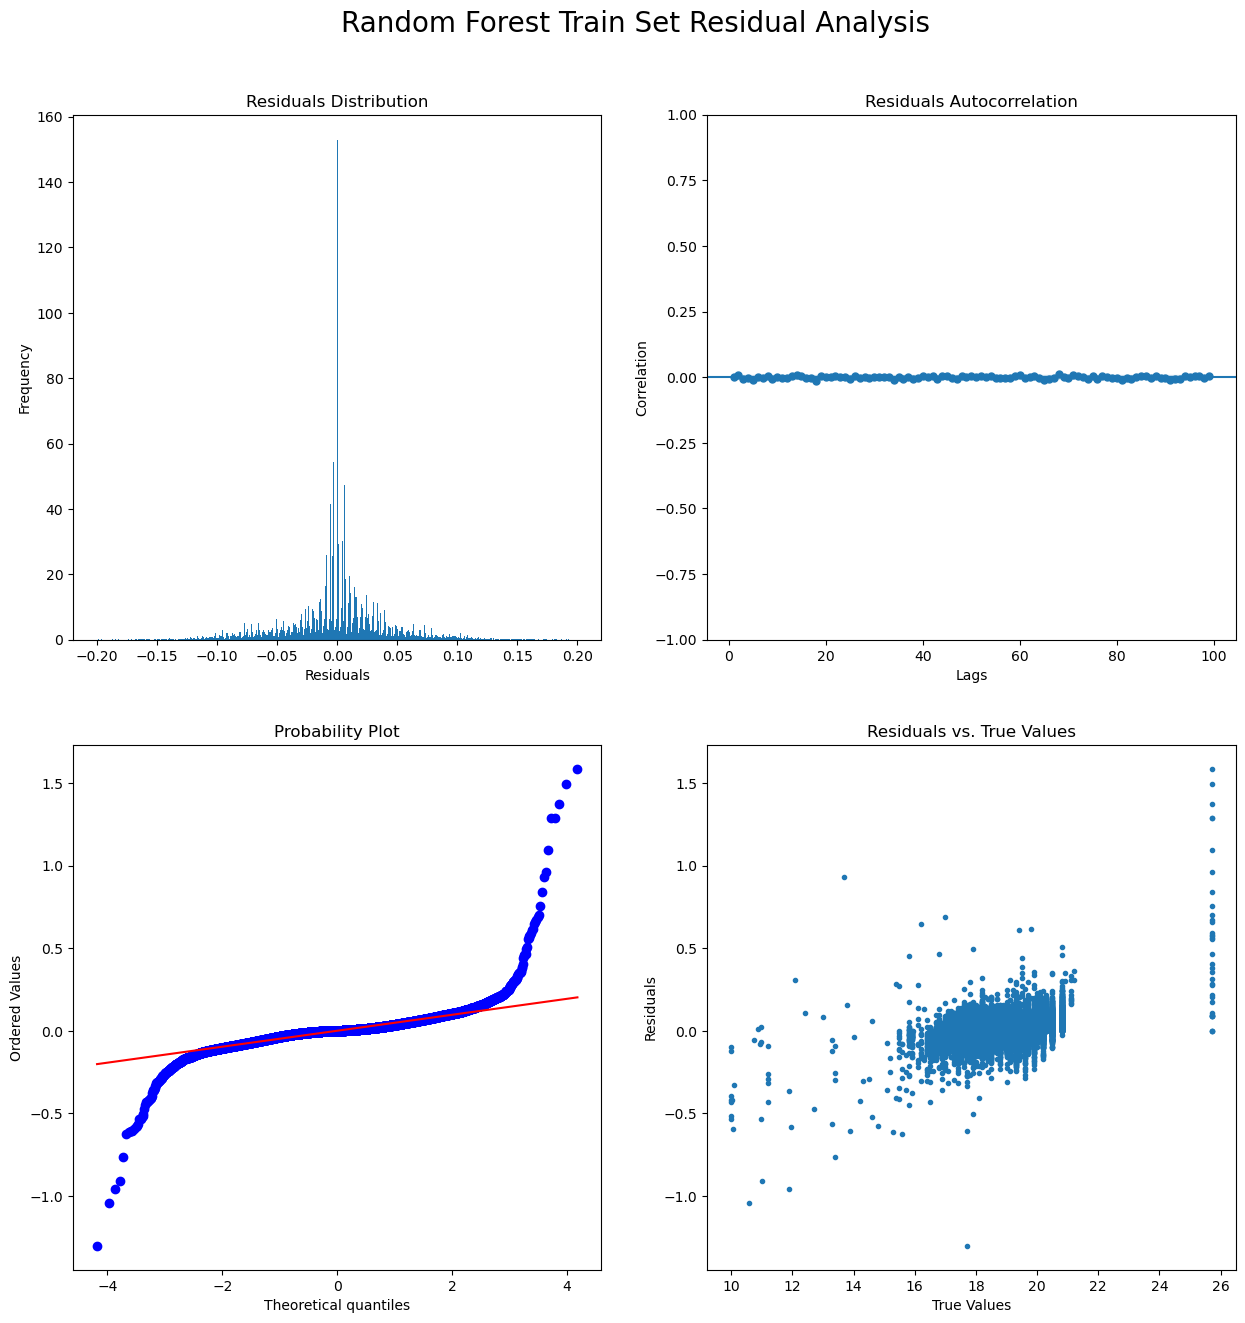

In [79]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.2,0.2), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [80]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.017283858883357525
MAE Test Set =  0.08369275082068169
RMSE Test Set =  0.131468090742041
MAPE Test Set =  0.004527427518070341


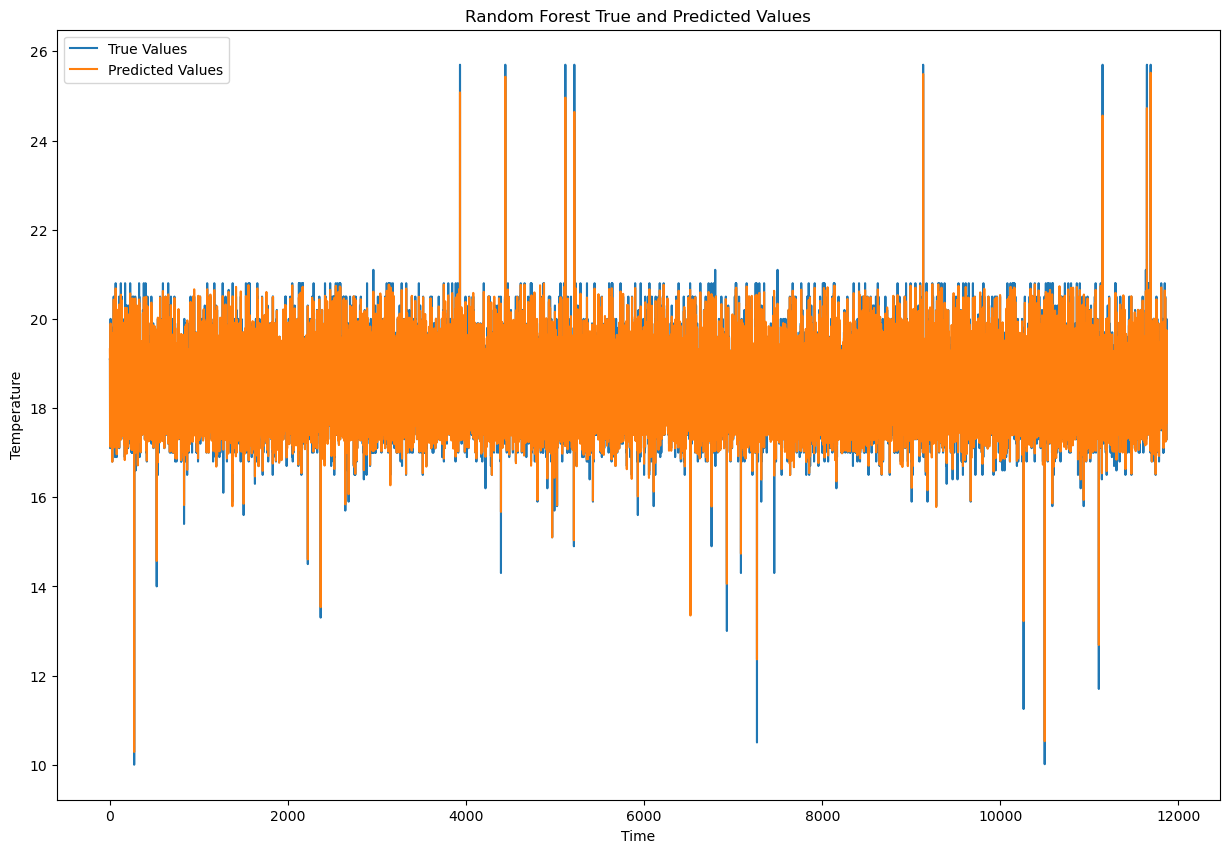

In [81]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

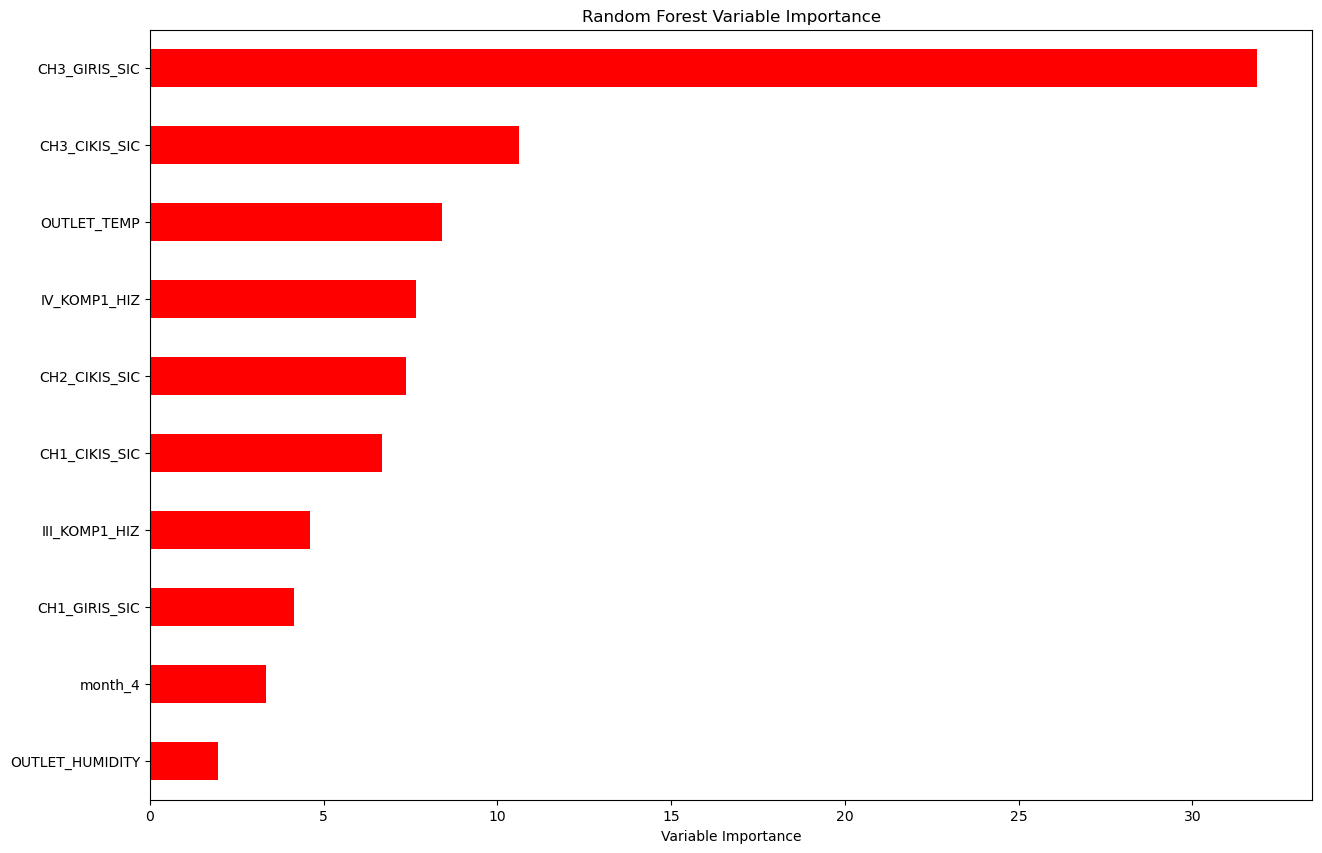

In [82]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

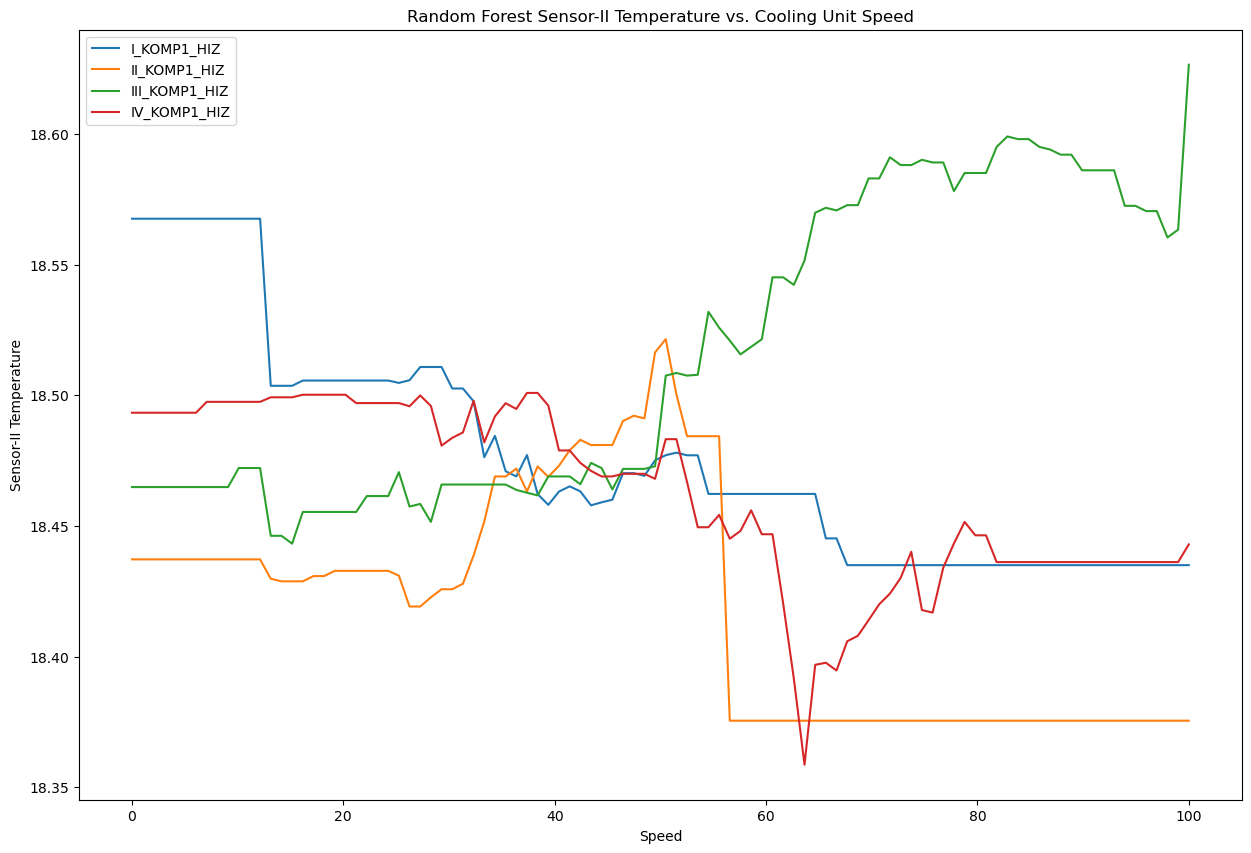

In [83]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Random Forest Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [84]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return result

In [85]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [86]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
maetrain = np.mean(np.abs(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('MAE Train Set = ', maetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.027533124616629805
MAE Train Set =  0.10741878129648945
RMSE Train Set =  0.16593108393736783
MAPE Train Set =  0.005718316131167194


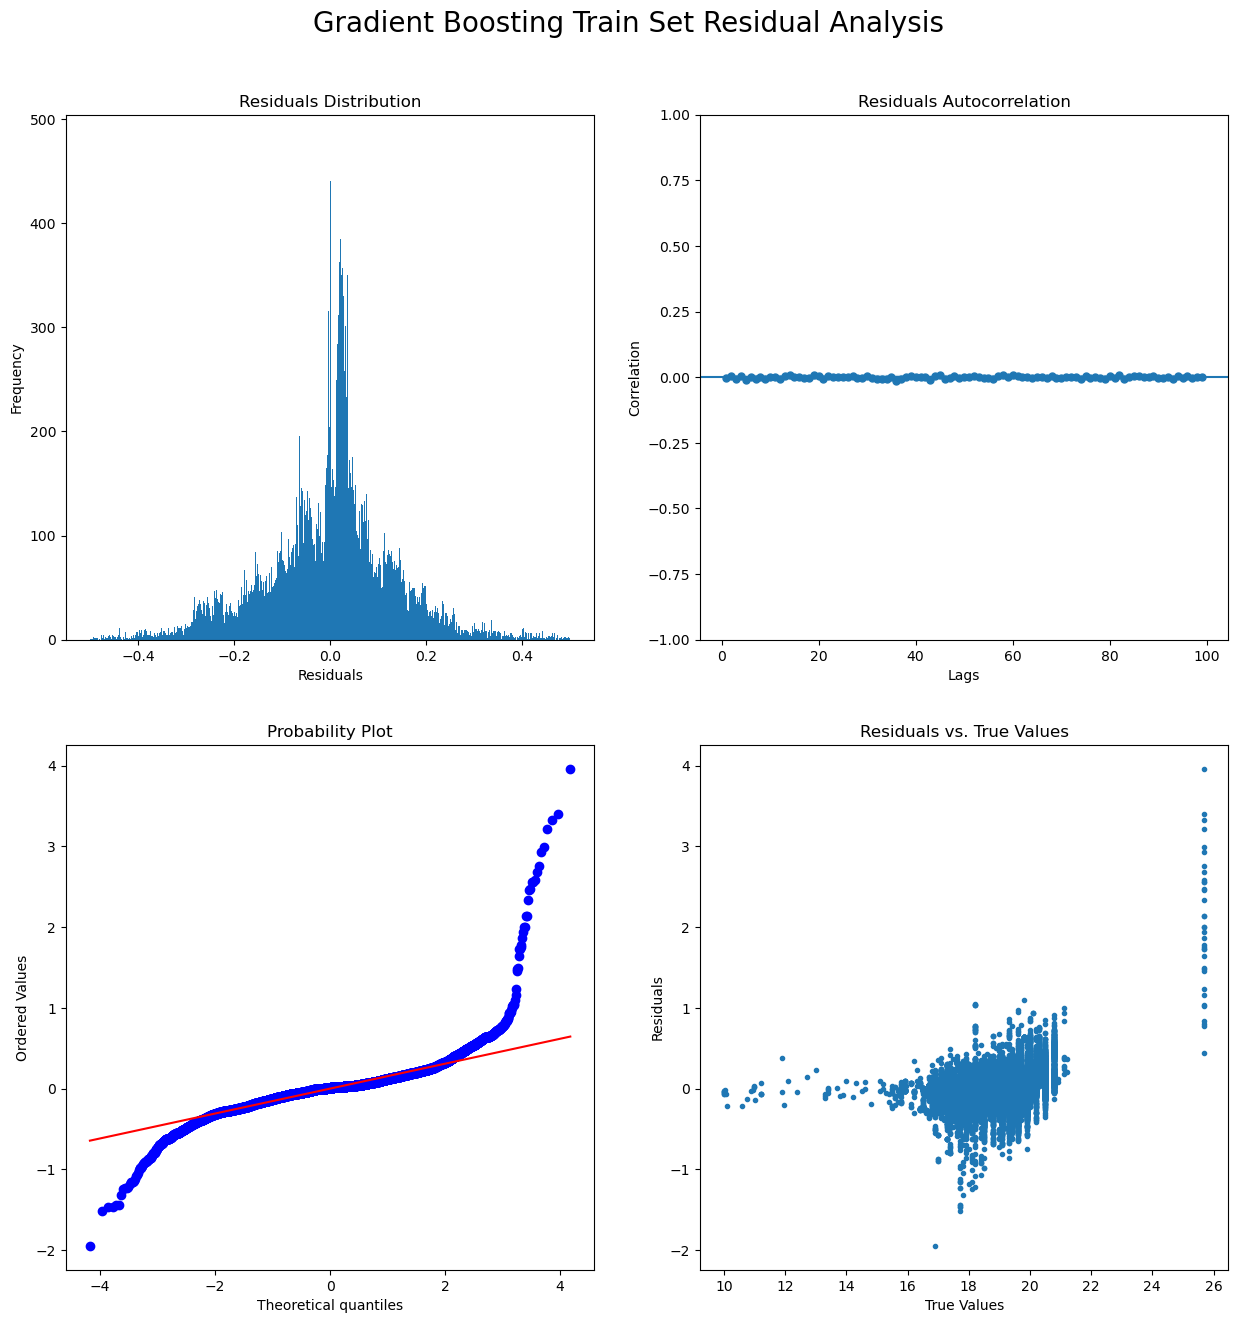

In [87]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [88]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.029158630428060796
MAE Test Set =  0.10948788577339044
RMSE Test Set =  0.17075898344760898
MAPE Test Set =  0.005833541102888729


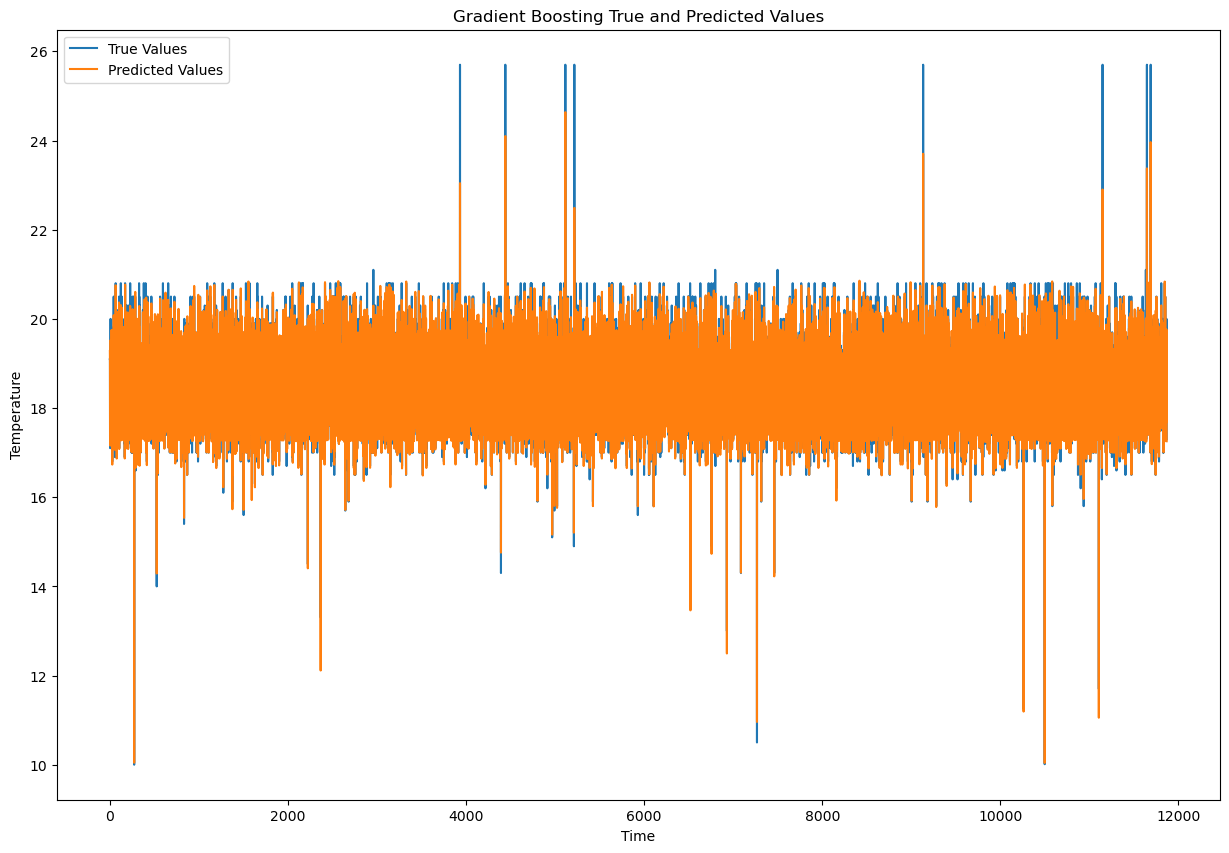

In [89]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

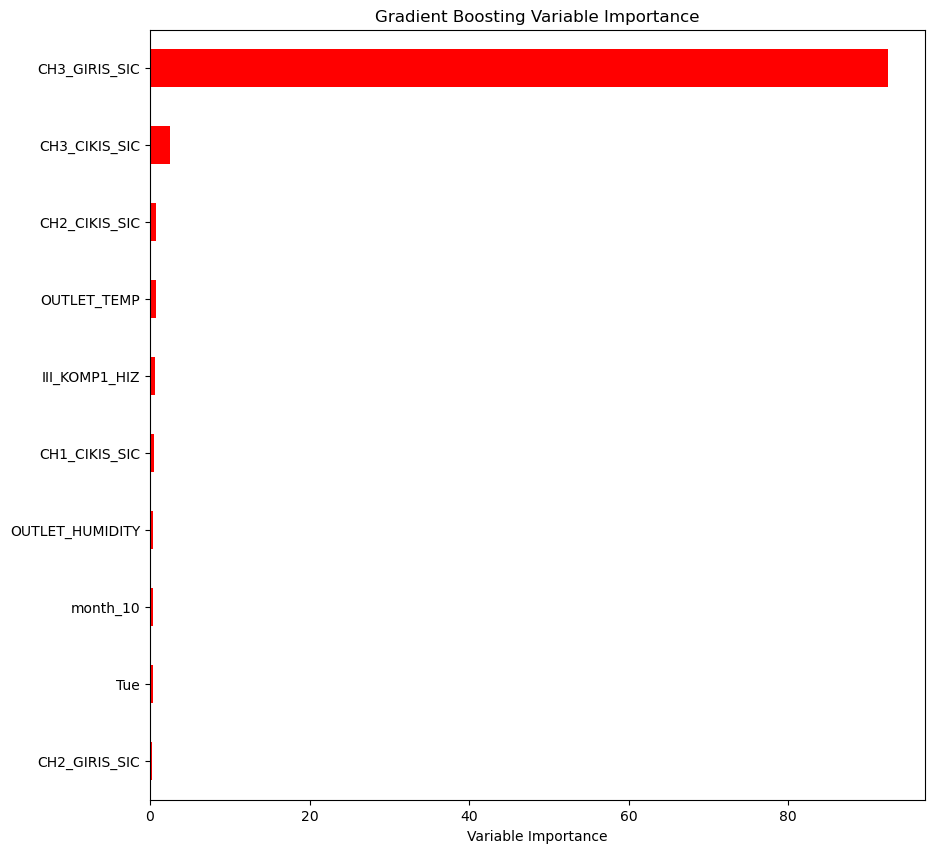

In [90]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

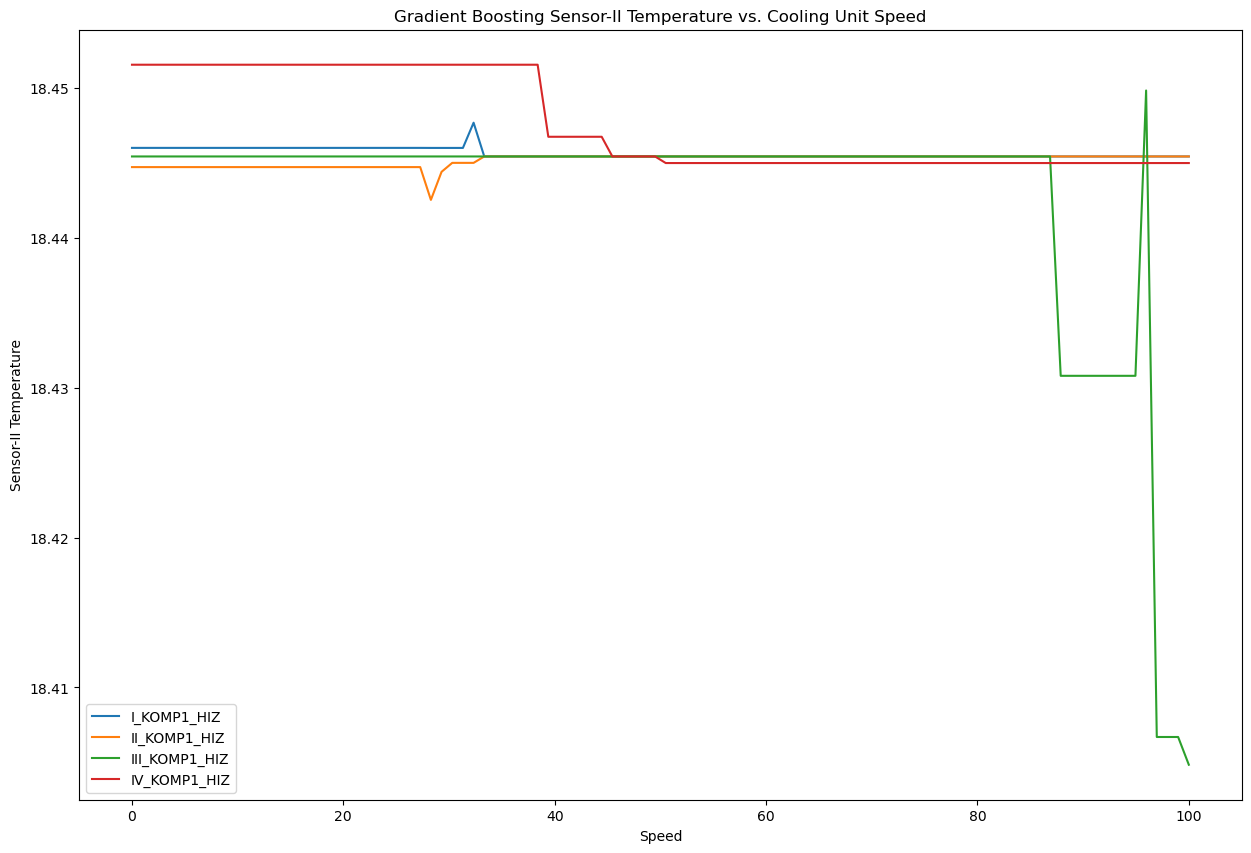

In [91]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Lasso

In [92]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [93]:
lasso_model, predictors = lasso(alpha=0.00002)

In [94]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['CH3_GIRIS_SIC'], dtype='object')


In [95]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.17165474005537645
MAE Test Set =  0.23728259200866955
RMSE Test Set =  0.4143123701452522
MAPE Test Set =  0.012573173331739467


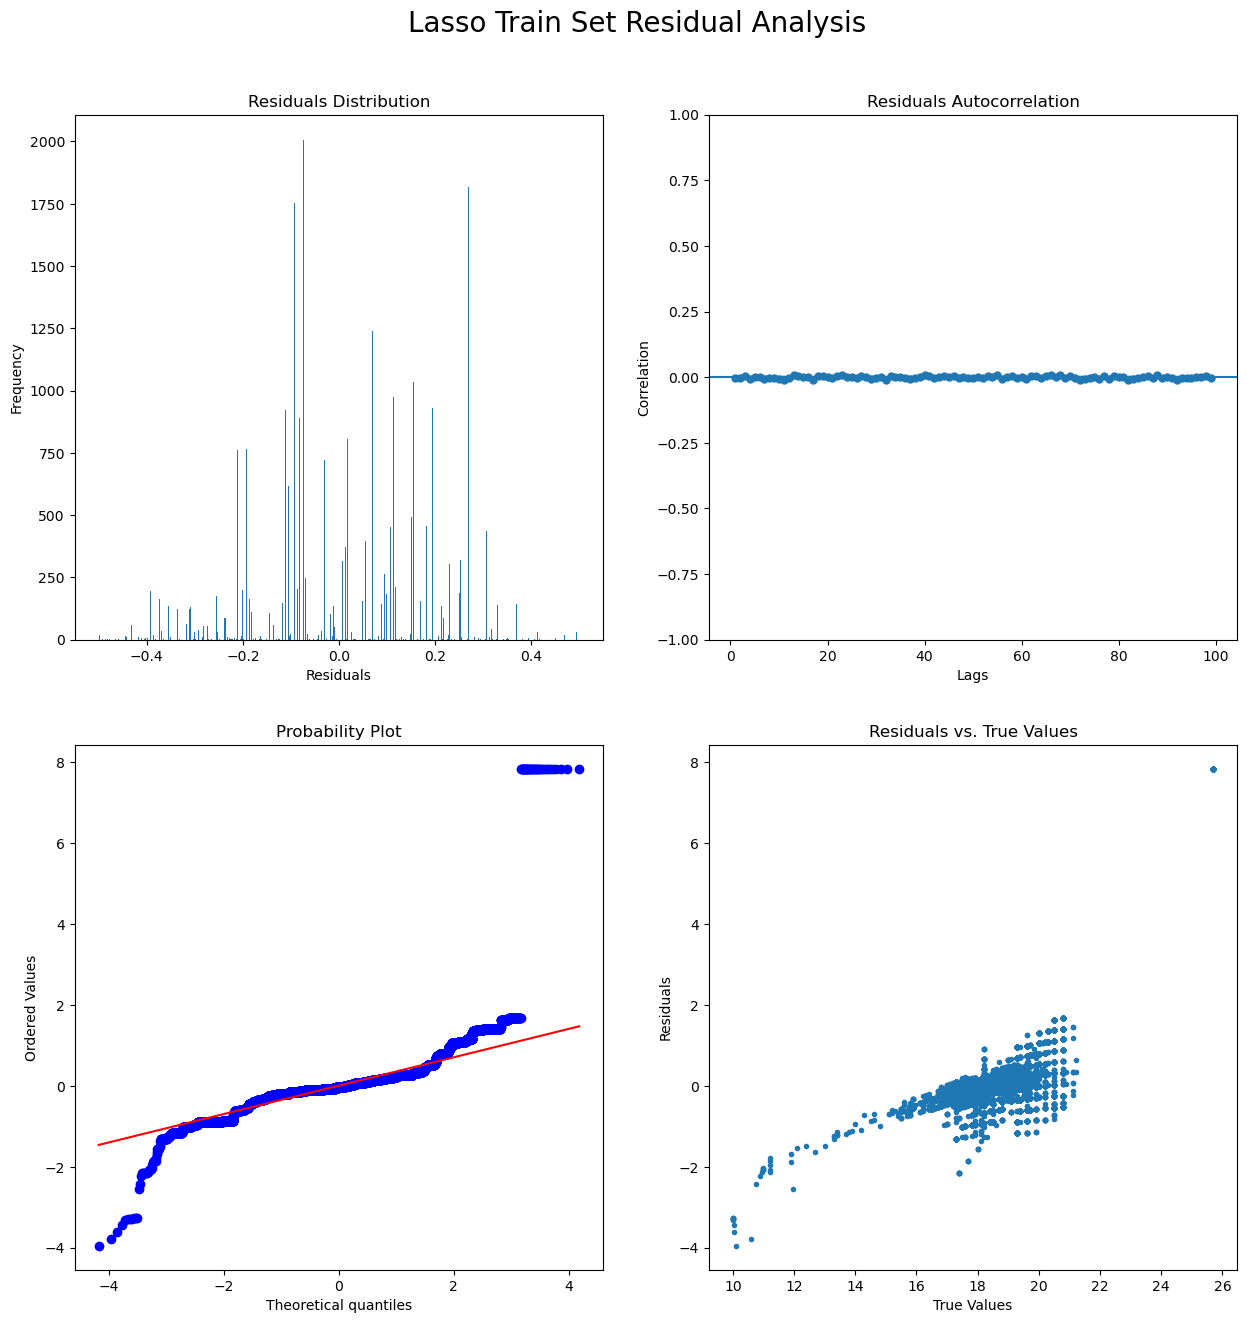

In [96]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [97]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
maetest = np.mean(np.abs(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('MAE Test Set = ', maetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.16500249655638777
MAE Test Set =  0.23665270774769662
RMSE Test Set =  0.40620499326865467
MAPE Test Set =  0.012539094572981491


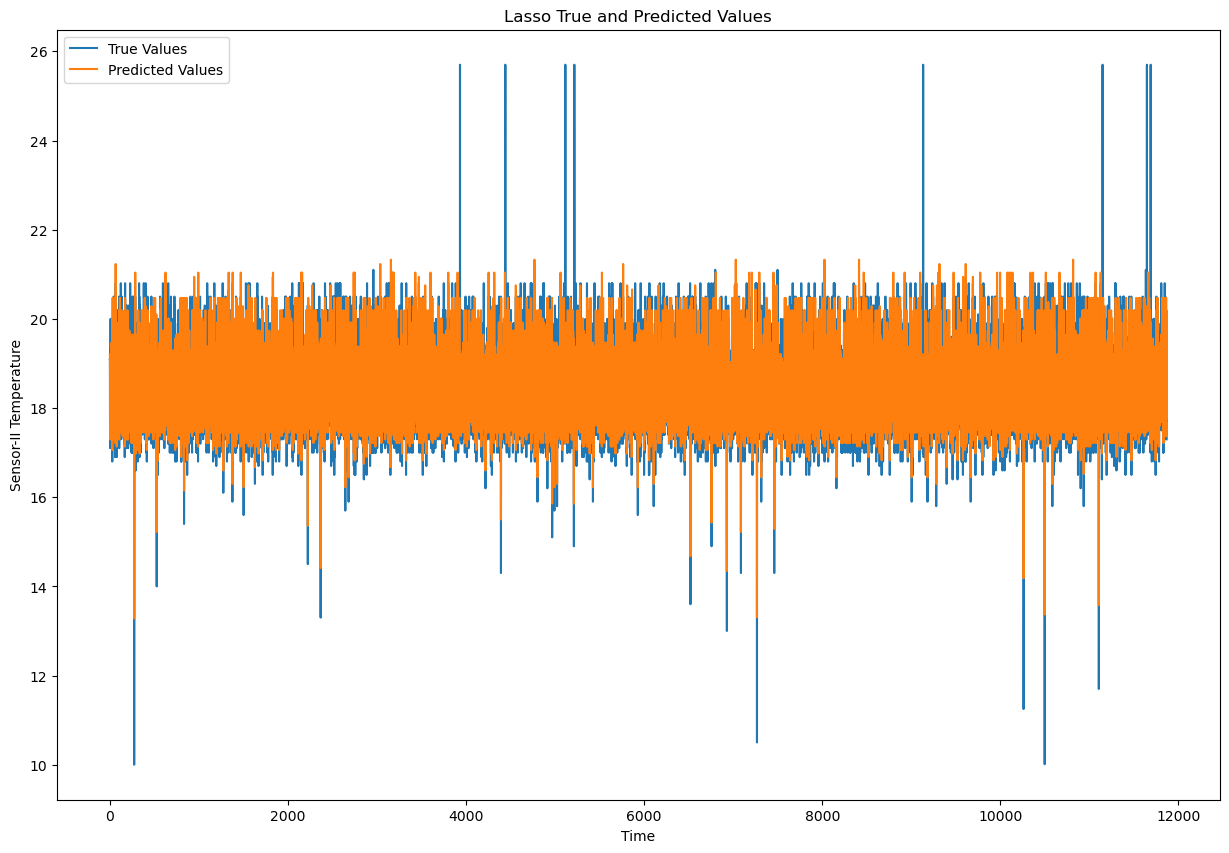

In [98]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()